# Script for fluorescence analysis in neurites

Importing basic libraries used in this code. Before running the code, make sure all of the following packages are installed in your environment. Alternatively, create a new environment using the environment.yml file provided in the repository.

In [1]:
#import basic libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas
from scipy.signal import find_peaks, peak_widths, butter, filtfilt
from scipy.ndimage import gaussian_filter, percentile_filter
import imageio
import os
import fnmatch
import datetime
import random
import time
from tkinter import Tk
from tkinter.filedialog import askdirectory, askopenfilename
window = Tk()
window.wm_attributes('-topmost', 1) #this displays the tk window on top of other windows
window.withdraw()   # this supress the tk window

''

In the next cell, you will be asked to select the metadata file containing the strain information. For the sample data provided in the repository, select the 'strain_key.xlsx' file. You can update this file to add new strain information or create another file with the same column structure. Remember to be consistent in maintaining the correct syntax for each field to avoid errors. The code matches the information from the image filename to the fields in this metadata sheet; so the strain identifier used in the filename must match what is entered in either the 'Strain_code' or the 'Strain' field. If you have images of the same strain taken under different microscope or camera settings (different microscope, objective or binning), store them in a separate folder and analyze them separately.

In [2]:
strain_key_path = askopenfilename(title='Select strain_key spreadsheet file',parent=window) # show an "Open" dialog box and return the path to the selected file

strain_key=pandas.read_excel(strain_key_path)


In the following cell, we specify the desired columns for the output dataframes.

In [3]:
#specify columns of the pandas dataframe and excel sheets
cols_Data =     ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Objective', 'Age', 'Distance', 'Normalized distance', 'Neurite intensity', 'Height_cutoff', 'Punctate fluorescence', 'Diffuse fluorescence']
cols_Peaks =    ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Objective', 'Age', 'Coordinate', 'Distance', 'Normalized distance', 'Punctum max intensity', 'Punctum width', 'Colocalization']
cols_IPDs =     ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Objective', 'Age', 'Distance', 'Normalized distance', 'Inter-punctum interval']
cols_Analysis = ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Objective', 'Age',
                 'Max neurite length', 'Total peaks', 
                 'Total fluorescence', 'Total diffuse fluorescence', 'Total puncta fluorescence',
                 'Average fluorescence', 'Average diffuse fluorescence', 'Average puncta fluorescence']

cols_fluortypes = ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Age', 'Distance', 'Normalized distance', 'Neurite intensity', 'Diffuse fluorescence', 'Vesicle fluorescence', 'Non-vesicle puncta fluorescence']
cols_Coloc = ['Date', 'Strain', 'Allele', 'Label', 'Neuron', 'ImageID', 'Age',
              'Total green peaks', 'Total red peaks', 'Coloc_GR', 'Coloc_RG', 'Frac_GR', 'Frac_RG',
              'Total fluorescence', 'Total diffuse fluorescence', 'Total vesicle fluorescence', 'Total non-vesicle puncta fluorescence']
cols_ICQ = ['Strain', 'Labels', 'Allele', 'Green_ImageID', 'Red_ImageID', 'Length', 'Segment', 'pair_selection', 'ICQ', 'Pearson coefficient']

## The next several cells contain user defined functions

The function 'pixel_conversion' takes the arguments for binning and objective and returns the scale of the image in microns/pixel

In [4]:
def pixel_conversion(binning,objective):
    f=int(binning[0])
    mu_per_px = cpw*f/objective
    return(mu_per_px)

The function 'neurite_fluorescence' takes a single channel of image, calculates the background subtracted neurite fluorescence as a function of the distance from the cell body. It also applies a smoothing function to reduce noise and further subtract baseline fluorescence to generate a trace that is used for the detection of peaks. This modified trace is only used for detection of peak positions and peak widths, and not for measuring peak intensities.

In [5]:
def neurite_fluorescence(img,label,binning): 
    if binning=='1x1':   
        n = img[7:13, :]                       #extract rows to use for neurite
        bg = np.concatenate((img[0:5, :], img[15: , :]))   #extract rows to use for background
        rawf = np.mean(n, axis=0)               #calculate average raw neurite fluorescence
        bgf = gaussian_filter(np.mean(bg, axis=0), sigma=10)             #calculate average background fluorescence
        nf = rawf - bgf                         #calculate background subtracted neurite fluorescence
        for i in range(0,len(nf)): 
            if nf[i]<0: nf[i]=0
        B, A = butter(2, 0.2)
        fnf_1 = filtfilt(B,A, nf)              #filter to smooth data
        bsf = percentile_filter(fnf_1,5,50)     #calculate baseline. this is useful only for MEC-4 signal where there is a sizable diffuse fraction
        fnf = fnf_1-bsf                       #subtract baseline 
    elif binning=='2x2':
        n = img[3:7, 0:]                       #extract rows to use for neurite
        bg = np.concatenate((img[0:2, 0:], img[8: , 0:]))   #extract rows to use for background
        rawf = np.mean(n, axis=0)               #calculate average raw neurite fluorescence
        bgf = gaussian_filter(np.mean(bg, axis=0), sigma=5)             #calculate average background fluorescence
        nf = rawf - bgf                         #calculate background subtracted neurite fluorescence
        for i in range(0,len(nf)): 
            if nf[i]<0: nf[i]=0
        B, A = butter(2, 0.4)
        fnf_1 = filtfilt(B,A, nf)              #filter to smooth data
        bsf = percentile_filter(fnf_1,5,50)     #calculate baseline. this is useful only for MEC-4 signal where there is a sizable diffuse fraction
        fnf = fnf_1-bsf                       #subtract baseline 

    return(fnf_1, bsf, fnf)

The function 'height_cutoff' calculates the threshold parameters for peak detection. These parameters are calculated from the smoothed neurite trace for each image.
Since imaging settings as well as overall intensity profiles differ for different proteins, this function applies slightly different parameters for each type that were manually optimized to give the best results for that type in pilot experiments.

In [6]:
def height_cutoff(label,fnf):
    if label=='mNG::MEC-4':
        avnoise=percentile_filter(fnf,50,500)
        stdnoise=np.std(fnf[fnf<np.percentile(fnf,25)])
        height=avnoise+10*stdnoise
    elif label=='mCh::RAB-3':
        avnoise=np.mean(fnf[fnf<np.percentile(fnf,90)])
        stdnoise=np.std(fnf[fnf<np.percentile(fnf,50)])
        height=np.array([avnoise+10*stdnoise]*imsize)
    else:
        avnoise=np.mean(fnf[fnf<np.percentile(fnf,75)])
        stdnoise=np.std(fnf[fnf<np.percentile(fnf,50)])
        height=np.array([avnoise+5*stdnoise]*imsize)
    prominence=0.2*height
    return(height,prominence)

The function 'peakfinder' detects the peaks in the smoothed neurite signal, according to the height and width of the detected peaks. Then it calculates the inter-punctum intervals, peak heights, diffuse and punctate fluorescence fractions.

In [7]:
def peakfinder(fnf, height, prominence, nf, dist):  
    peaks = find_peaks(fnf, height=height, prominence=prominence)[0]
    pmi = [fnf[i] for i in peaks]
    pw = peak_widths(fnf, peaks, rel_height=0.5)
    
    # only keep wide peaks if they are also bright
    indices=[]
    for i in np.arange(0, len(peaks)):
        if pw[0][i]>12 and pw[0][i]<16 and pmi[i]<1.2*height[peaks[i]]: indices = indices+[i]
        elif pw[0][i]>=16 and pmi[i]<1.5*height[peaks[i]]: indices = indices+[i]
    peaks=np.delete(peaks,indices)
    pmi=np.delete(pmi,indices)
    pw = peak_widths(fnf, peaks, rel_height=0.5)

    pd=peaks*mu_per_px
    pnd = pd/dist[-1]
    pmi_nf = [nf[i] for i in peaks]
    ipd = np.diff(pd)
    ipdd = [pd[i+1] for i in range(0,len(ipd))]
    ipdnd = ipdd/dist[-1]
        
    #compute diffuse fluorescence
    df=np.copy(nf)
    pw2=peak_widths(fnf, peaks, rel_height=0.75)
    for i in np.arange(0, len(peaks)):
        indices2=np.arange(int(pw2[2][i])-1,int(pw2[3][i])+2)
        df[indices2]=np.nan
        df=np.interp(np.arange(len(df)), 
              np.arange(len(df))[np.isnan(df) == False], 
              df[np.isnan(df) == False])   
    pf = nf-df
    
    return(df, pf, peaks, pd, pnd, pmi, pmi_nf, ipd, ipdd, ipdnd, pw)


The function 'colocalization' takes two sets of peak positions, and calculates if the peaks from one set co-localize with the peaks from the second set. For the sample data, if two peaks are less than 0.5 microns apart they are considered to be co-localized.

In [8]:
def colocalization(A,B,binning):
    coloc=[]
    n=0
    for peak in A:
        yn='no'
        if binning=='1x1':
            for p in np.arange(peak-4, peak+5):
                if p in B:
                    yn = 'yes'
                    n=n+1
                    break
        if binning=='2x2':
            for p in np.arange(peak-2, peak+3):
                if p in B:
                    yn = 'yes'
                    n=n+1
                    break
        coloc=np.append(coloc, yn)
    return(coloc,n)

The function 'corr_coeffs' takes two single channel images and calculates the intensity correlation quotient (ICQ) and Pearson's correlation coefficient. 

In [9]:
def corr_coeffs(rawG, rawR):
    nG = rawG[7:13]
    nR = rawR[7:13]
    bgG= np.concatenate((rawG[0:6, 0:], rawG[14: , 0:]))
    bgR= np.concatenate((rawR[0:6, 0:], rawR[14: , 0:]))
    G = np.subtract(nG, np.mean(bgG,axis=0))
    R = np.subtract(nR, np.mean(bgR,axis=0))
    dfmG = np.subtract(G,np.mean(G))
    dfmR = np.subtract(R,np.mean(R))
    pdm=np.multiply(dfmG,dfmR)                  #product matrix
    totalpx = np.shape(pdm)[0]*np.shape(pdm)[1] #total number of pixels in product matrix
    pospx = np.count_nonzero(pdm>0)             #total number of positive pixels
    icq=float(pospx)/totalpx - 0.5
    pearson = np.sum(pdm)/np.sqrt(np.sum(np.power(dfmG,2))*np.sum(np.power(dfmR,2)))
    return(icq, pearson)


The function 'plot_traces_data' plots the neurite intensity and marks the detected peaks in that trace. The images are also saved as .png files in the output directory.

In [10]:
def plot_traces_data(x,label,imsize,dist,nf,bsf,df,pd,pmi_nf,height):
    plt.figure(1, figsize=(0.010*imsize,8))
    plt.rcParams.update({'font.size': 30})
    plt.rcParams['svg.fonttype'] = 'none'
   
    plt.title(x+' '+label)
    plt.xlabel('Distance (um)')
    plt.ylabel('Intensity (AU)')
    plt.plot(dist, nf,'y-')
    plt.plot(dist, bsf+height,'b-')
    plt.plot(pd, pmi_nf, 'go')
    if label=='mNG::MEC-4': 
        plt.plot(dist, df,'k-')
    if label=='LAM-1::wSc' or label=='LAM-2::mNG':
        plt.axis([0, dist[-1], 0, 30])
    else:
        plt.axis([0, dist[-1], 0, 100])

    sns.set_style('white')
    sns.set_style('ticks', {'xtick.direction': 'in', 'ytick.direction': 'in'})
    sns.despine(offset=5, trim=False)

    plt.savefig(dfpath+timestamp+'/individual_traces/'+x[:-4]+'_'+label.replace('::','_')+'.png')
    
    plt.show()
    plt.close()
    return()


The function 'plot_coloc' plots the neurite intensity of two channels and marks the all the peaks detected as dots, and the peaks that are co-localized between the channels as blue vertical lines. The images are also saved as .png files in the output directory.

In [11]:
def plot_coloc(apG,apR):
    plt.figure(1, (0.010*imsize,20))
    grid = plt.GridSpec(2,1,hspace=0.3)
    
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['svg.fonttype'] = 'none'
    
    plt.subplot(grid[0,0])
    plt.title(x+' '+labelG)
    plt.xlabel('Distance (um)')
    plt.ylabel('Intensity (AU)')
    plt.axis([0, max(dist), 0, 100])
    plt.plot(dist, nfG, 'g-')
    plt.plot(dist, bsfG+heightG,'b-')
    plt.plot(pdG, pmi_nfG, 'go')
    if labelG=='mNG::MEC-4': 
        plt.plot(dist, dfG,'k-')
    if labelG=='LAM-2::mNG':
        plt.axis([0, dist[-1], 0, 30])
    else:
        plt.axis([0, dist[-1], 0, 100])
    plt.vlines(list(apG['Distance'][apG['Colocalization']=='yes']),0,list(apG['Punctum max intensity'][apG['Colocalization']=='yes']))
    
    plt.subplot(grid[1,0])
    plt.title(x+' '+labelR)
    plt.xlabel('Distance (um)')
    plt.ylabel('Intensity (AU)')
    plt.axis([0, max(dist), 0, 100])
    plt.plot(dist, nfR, 'r-')
    plt.plot(dist, bsfR+heightR,'b-')
    plt.plot(pdR, pmi_nfR, 'ro')
    if labelR=='LAM-1::wSc':
        plt.axis([0, dist[-1], 0, 30])
    else:
        plt.axis([0, dist[-1], 0, 100])
    plt.vlines(list(apR['Distance'][apR['Colocalization']=='yes']),0,list(apR['Punctum max intensity'][apR['Colocalization']=='yes']))

    sns.set_style('white')
    sns.set_style('ticks', {'xtick.direction': 'in', 'ytick.direction': 'in'})
    sns.despine(offset=20, trim=False)

    plt.savefig(dfpath+timestamp+'/individual_traces/'+x+'_coloc.png')
    plt.show()
    plt.close()

The function 'add_data_to_dataframe' organizes the data stored in different variable into structured dataframes.

In [12]:
def add_data_to_dataframe(date,strain,allele,label,neuron,x,objective,age,imsize,
                          dist,normdist,nf,df,pf,fnf,height,
                          peaks,pd,pnd,pmi_nf,pw,coloc,
                          ipdd,ipdnd,ipd,
                          df_Data,df_Peaks,df_IPDs,df_Analysis):
    all_data1 = pandas.DataFrame({'Date':[date]*imsize, 'Strain':[strain]*imsize, 'Allele':[allele]*imsize, 'Label':[label]*imsize, 'Neuron':[neuron]*imsize, 'ImageID':[x]*imsize, 'Objective':[objective]*imsize, 'Age':[age]*imsize, 'Distance':dist, 'Normalized distance':normdist, 'Neurite intensity':nf, 'Height_cutoff':height, 'Punctate fluorescence':pf, 'Diffuse fluorescence':df}, columns=cols_Data)
    df_Data=df_Data.append(all_data1)
    if len(pd)>0: all_data2 = pandas.DataFrame({'Date':[date]*len(pd), 'Strain':[strain]*len(pd), 'Allele':[allele]*len(pd), 'Label':[label]*len(pd), 'Neuron':[neuron]*len(pd), 'ImageID':[x]*len(pd), 'Objective':[objective]*len(pd), 'Age':[age]*len(pd), 'Coordinate':peaks, 'Distance':pd, 'Normalized distance':pnd, 'Punctum max intensity':pmi_nf, 'Punctum width':pw[0]*mu_per_px, 'Colocalization':coloc}, columns=cols_Peaks)
    else: all_data2 = pandas.DataFrame(columns=cols_Peaks)
    df_Peaks=df_Peaks.append(all_data2)
    if len(ipd)>0: all_data3 = pandas.DataFrame({'Date':[date]*len(ipd), 'Strain':[strain]*len(ipd), 'Allele':[allele]*len(ipd), 'Label':[label]*len(ipd), 'Neuron':[neuron]*len(ipd), 'ImageID':[x]*len(ipd), 'Objective':[objective]*len(ipd), 'Age':[age]*len(ipd), 'Distance':ipdd, 'Normalized distance':ipdnd, 'Inter-punctum interval':ipd}, columns=cols_IPDs)
    else: all_data3 = pandas.DataFrame(columns=cols_IPDs)
    df_IPDs=df_IPDs.append(all_data3)  
    frame = pandas.DataFrame([[date, strain, allele, label, neuron, x, objective, age, dist[-1], len(pd), np.sum(nf), np.sum(df), np.sum(pf), np.mean(nf), np.mean(df), np.mean(pf)]], columns=cols_Analysis)
    df_Analysis = df_Analysis.append(frame)
    return(all_data2, df_Data,df_Peaks,df_IPDs,df_Analysis)

# The following cells read and analyzes the data from the images, generates plots and organizes the data into dataframes.

In the next cell, you will be asked to select the directory where you want to save the output files. For the sample data, the output is stored in the directory 'sample_output' included in the repository.

In [13]:
dfpath = askdirectory(title='Select destination folder for saving analysis files',parent=window)+'/' # shows dialog box and return the path

In the next cell you will be asked to select the directory where the straightened images are stored. Then you will be asked to enter some details such as the camera pixel width, objective magnification, age of the worms and the type of neuron. Every time this cell is run it will store the output of the run in a new subfolder within the destination folder. The subfolders will be named with a unique timestamp to distinguish between runs. The dataframes will be saved as .pkl files which can be read and processed in a separate script for plotting data and further analysis.

NOTE:: For the mCh::RAB-3 and mNG::MEC-4 dual color images in the sample data, only 200 um of the neurite closest to the cell body is analyzed. Images where the neurite is less than 200 um are skipped over  and not analyzed.

Camera pixel width (um):7.54
Objective magnification (_x):60
Age of worms:Adult
Neuron:ALM


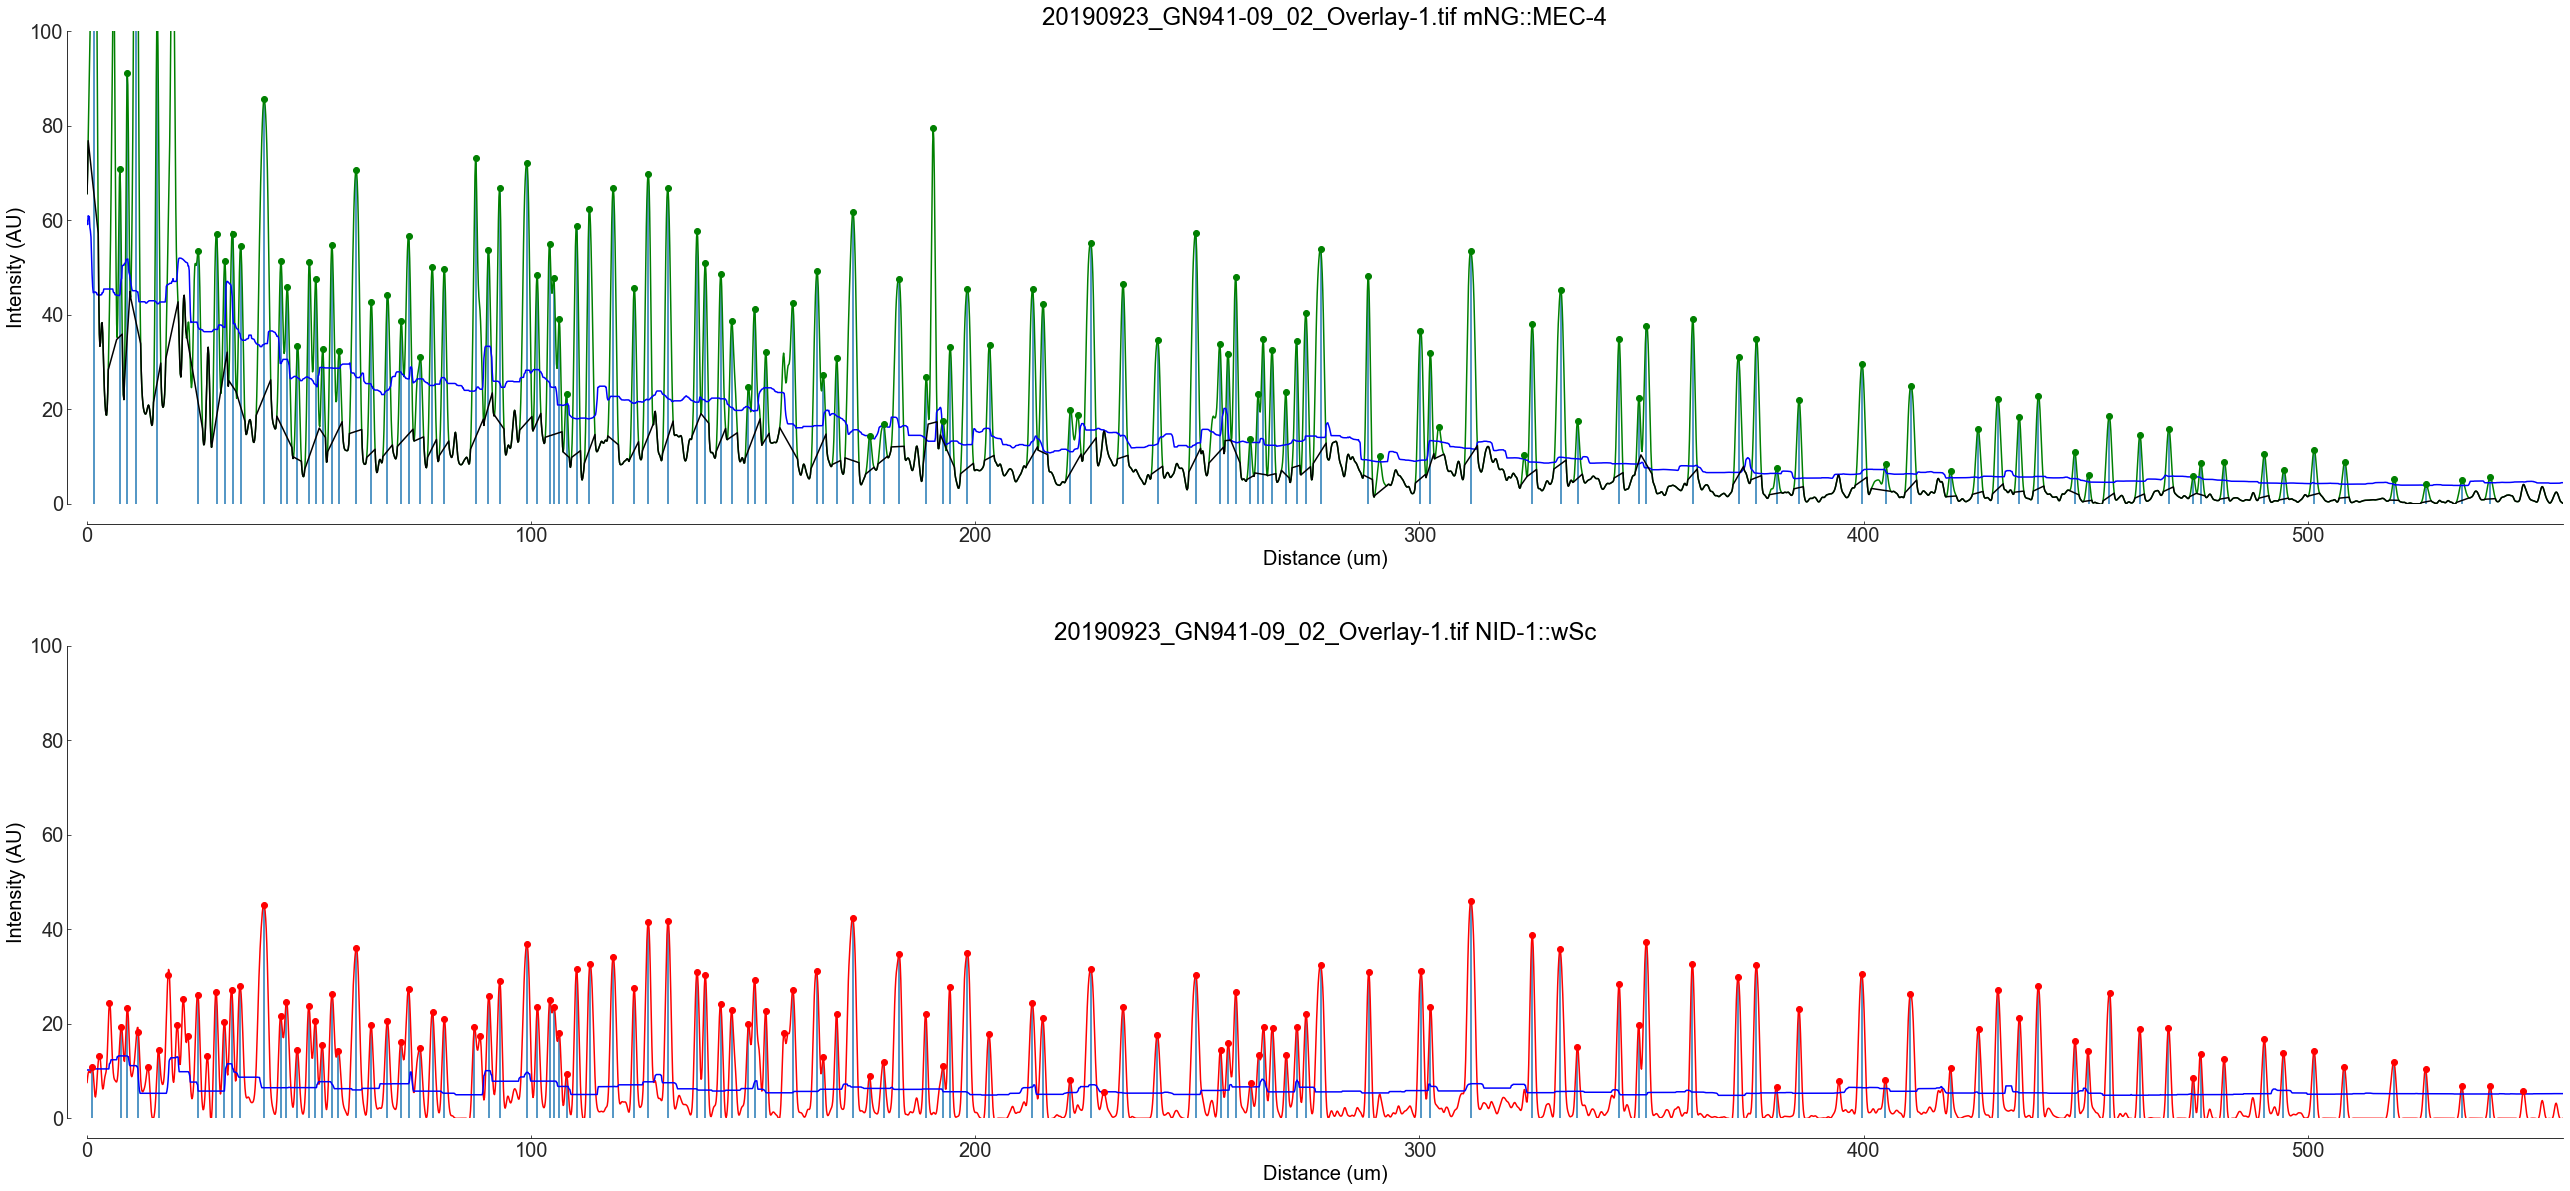

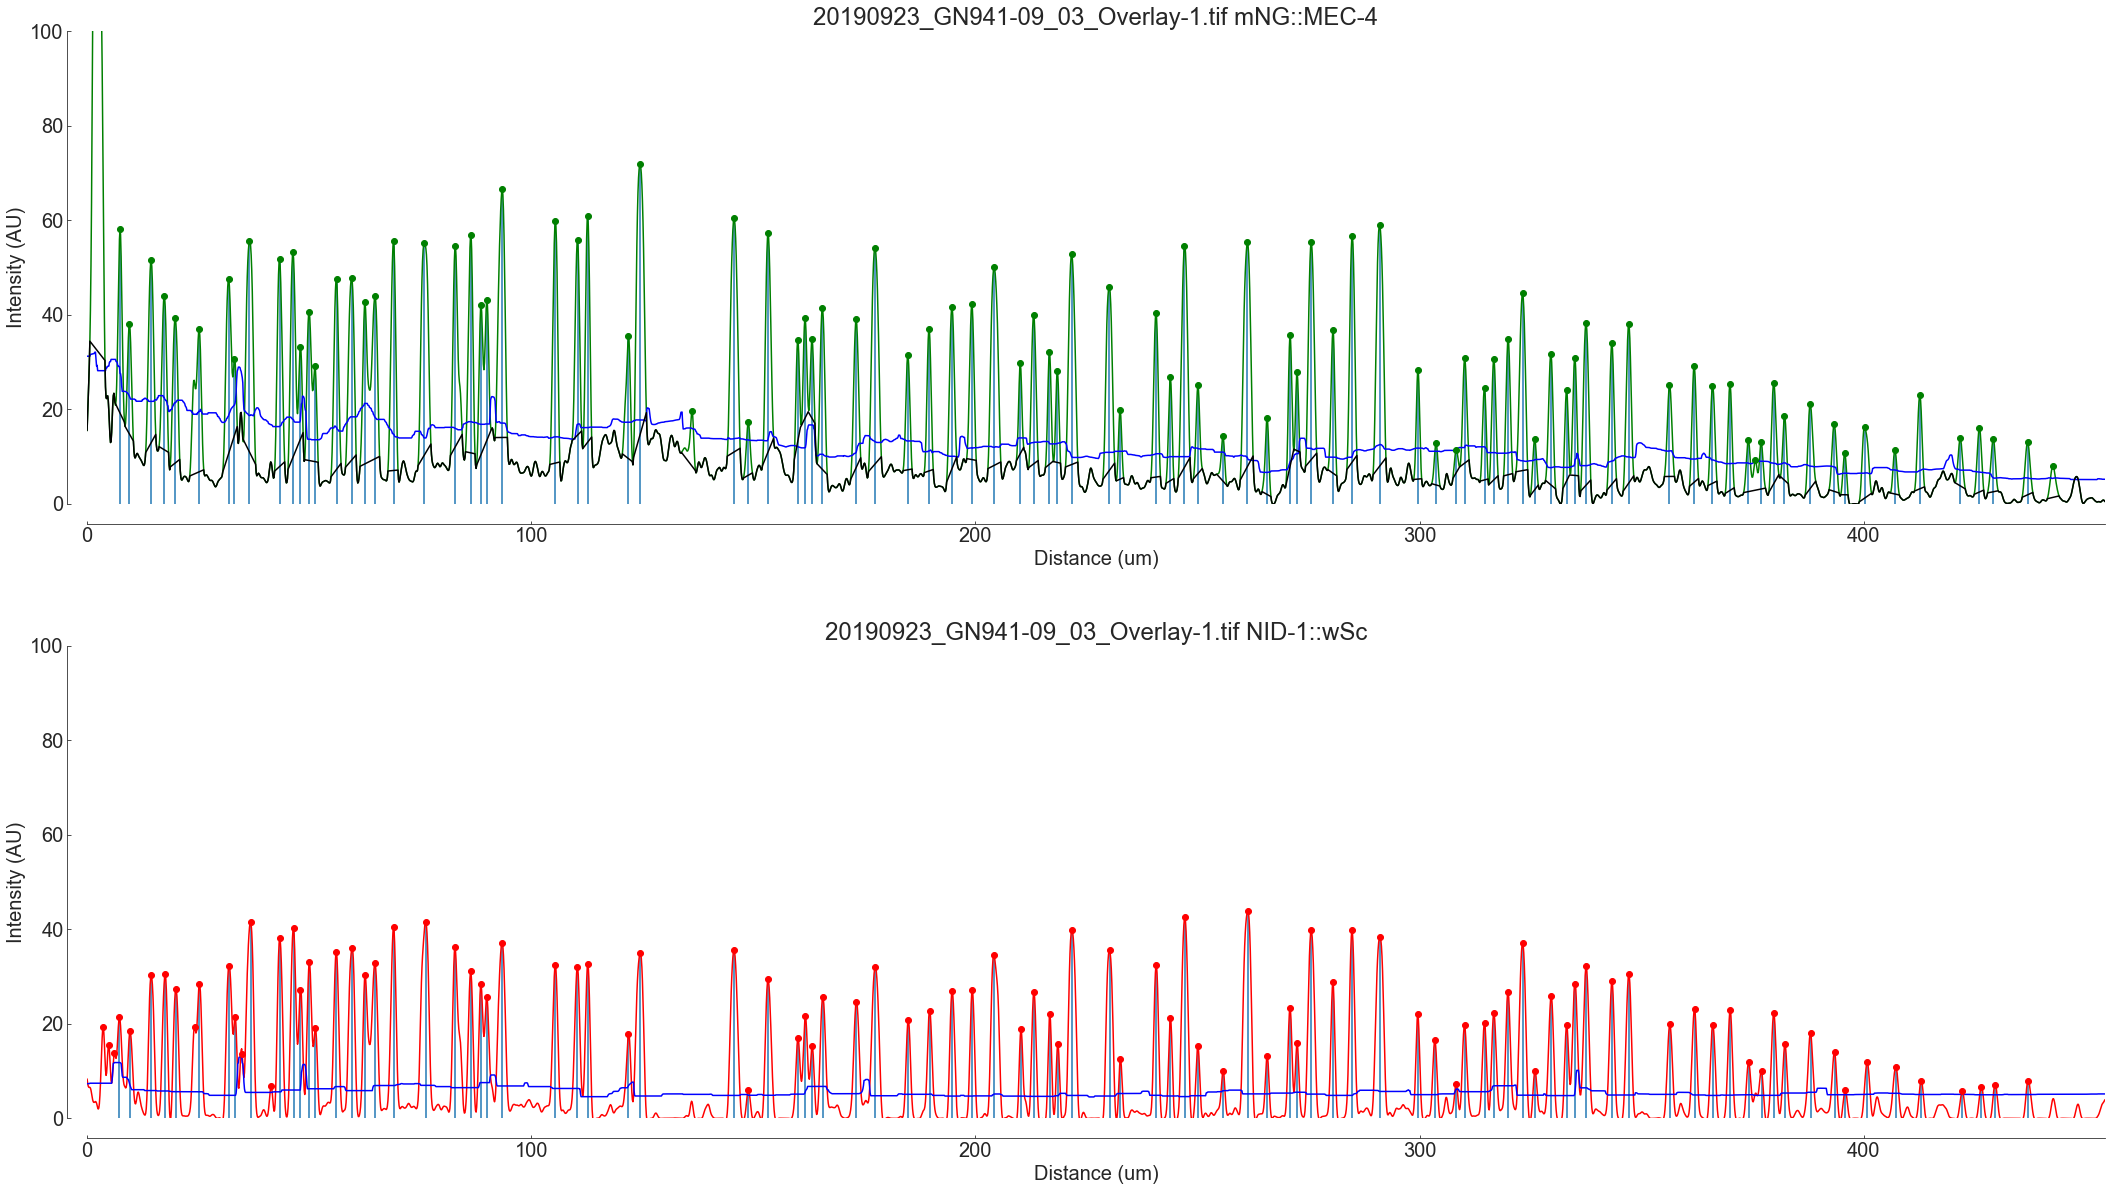

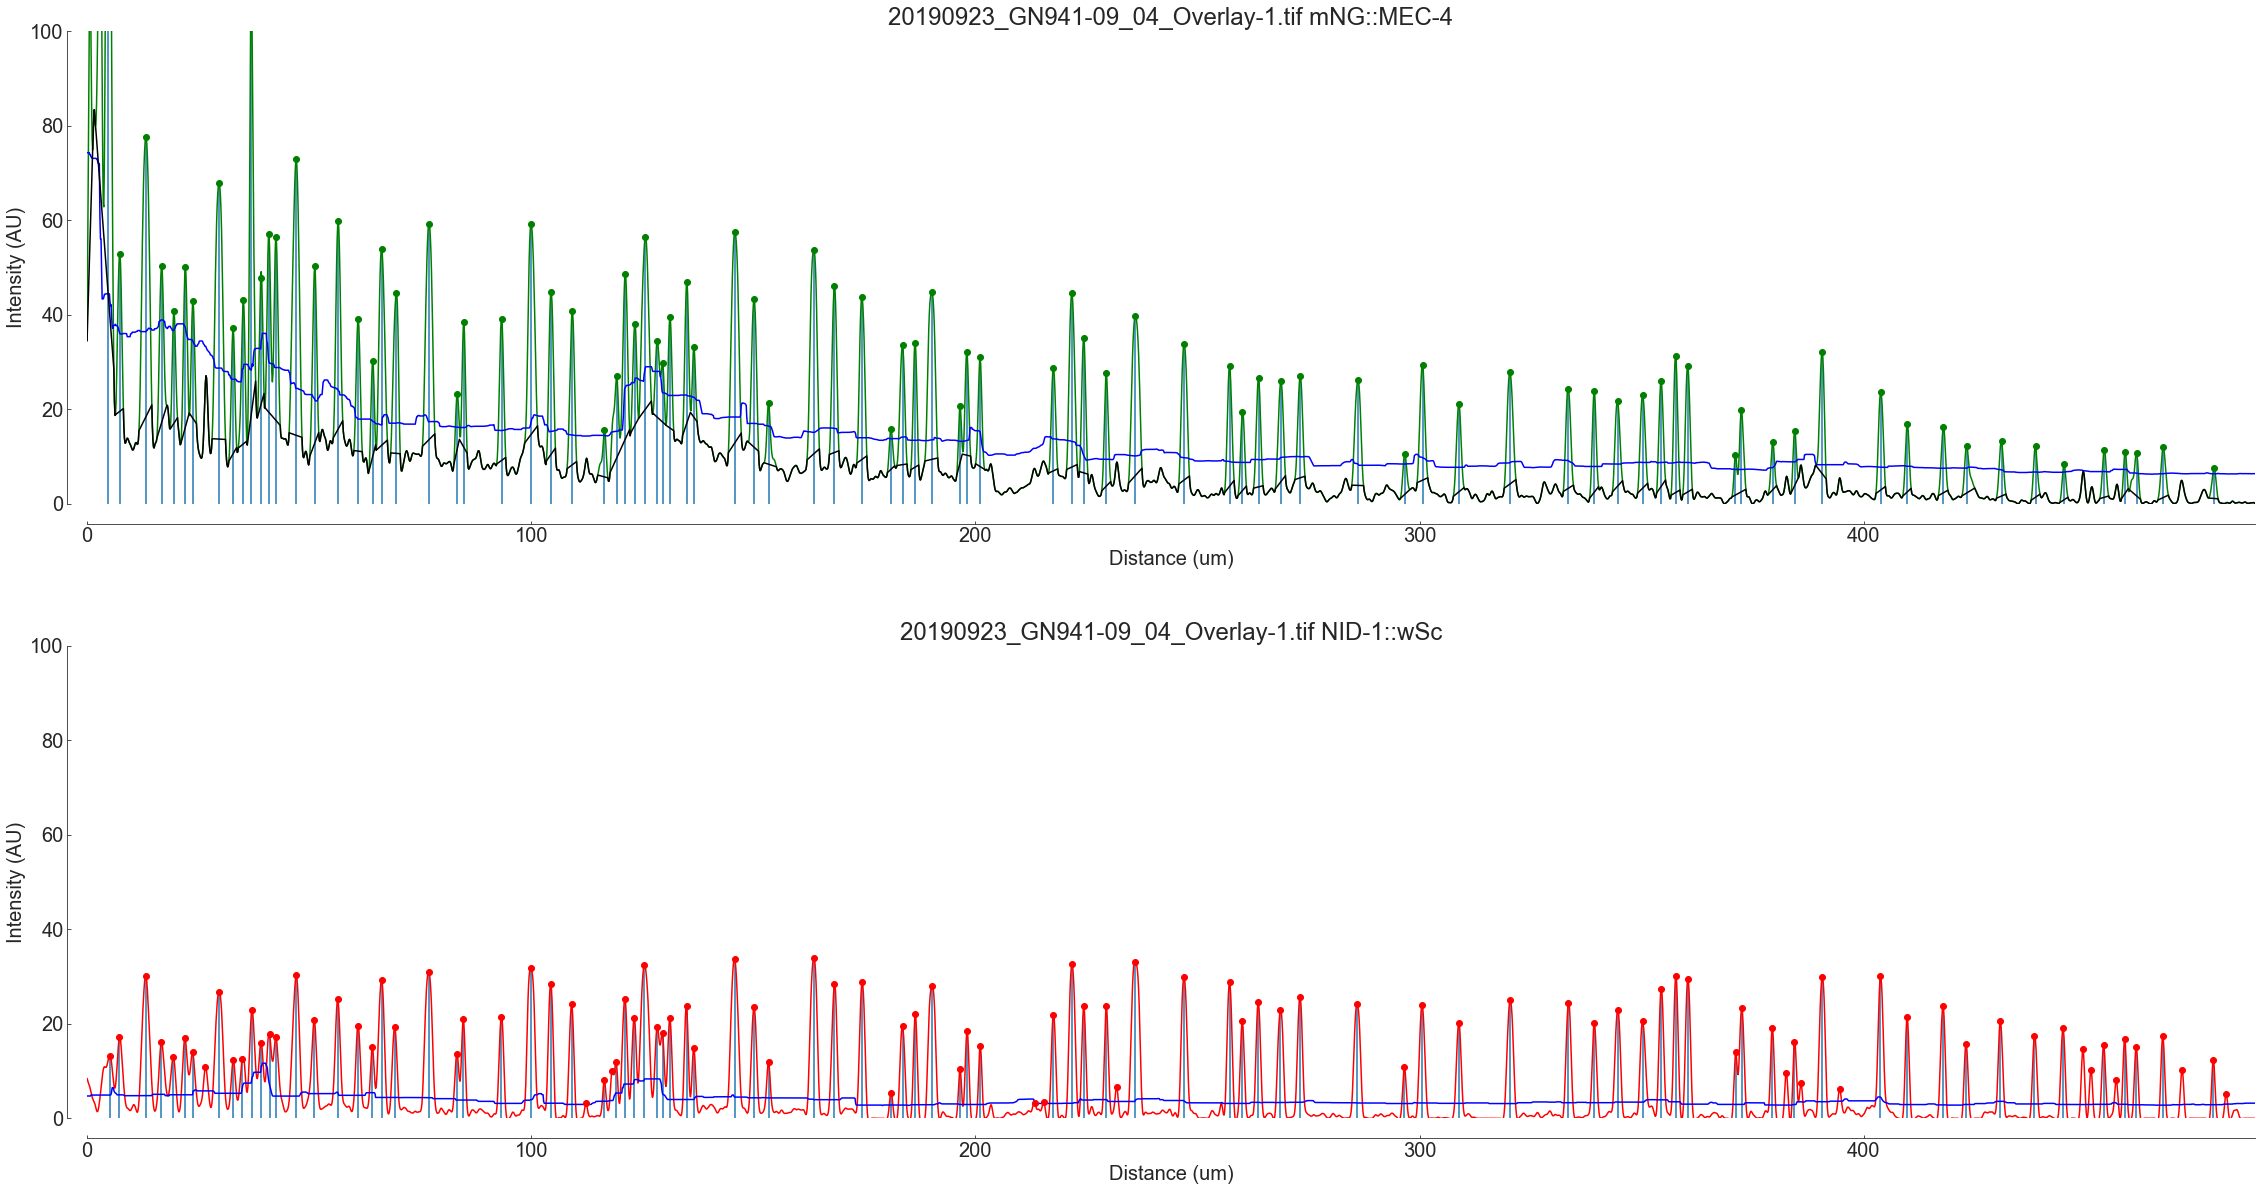

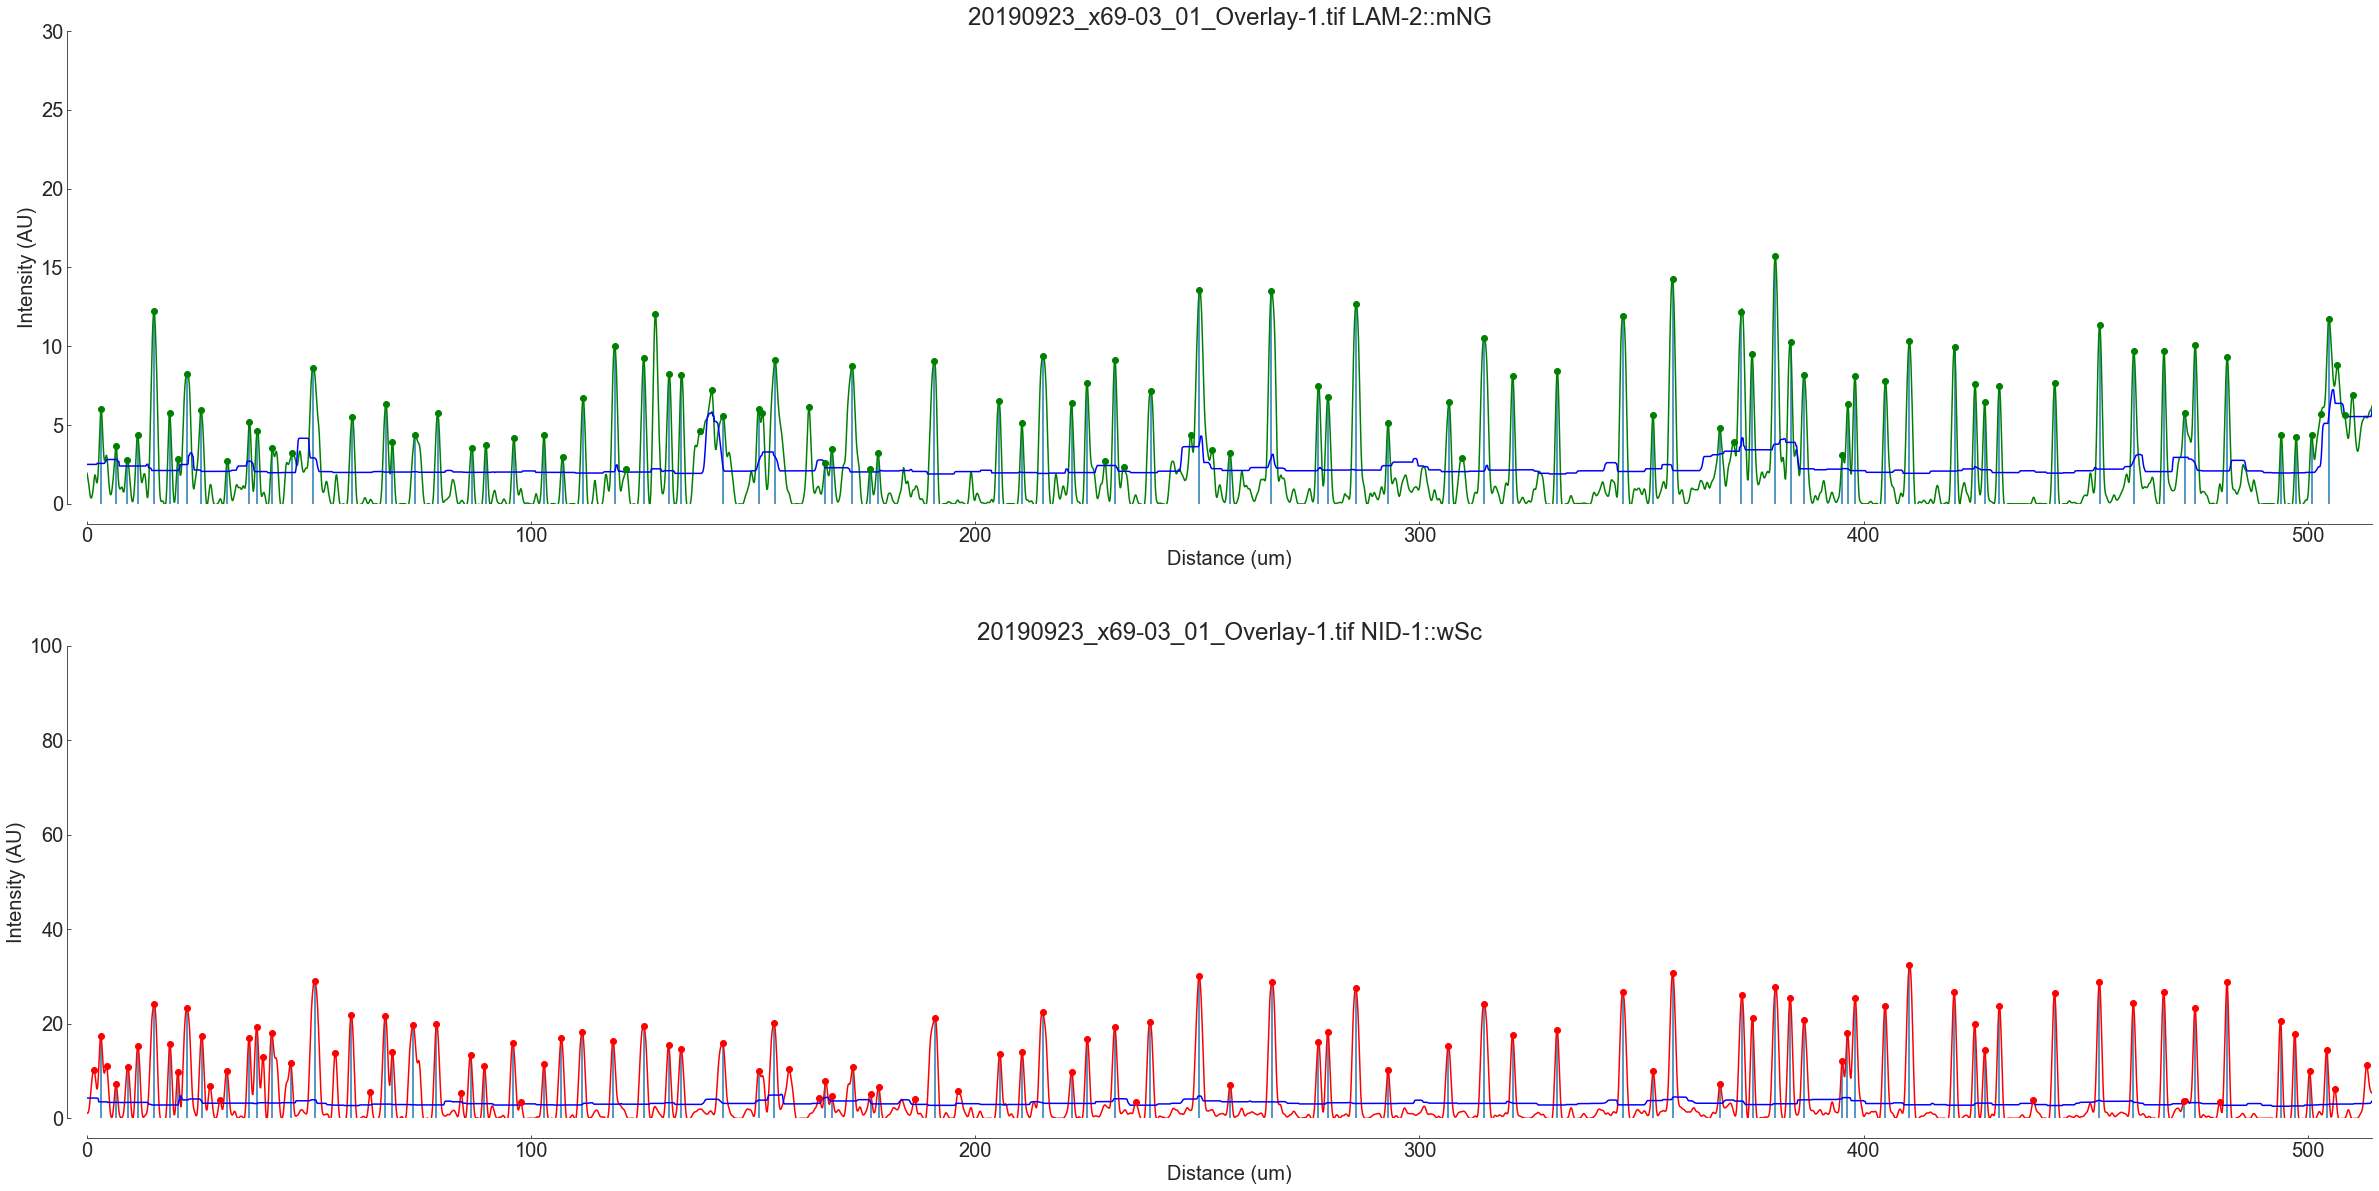

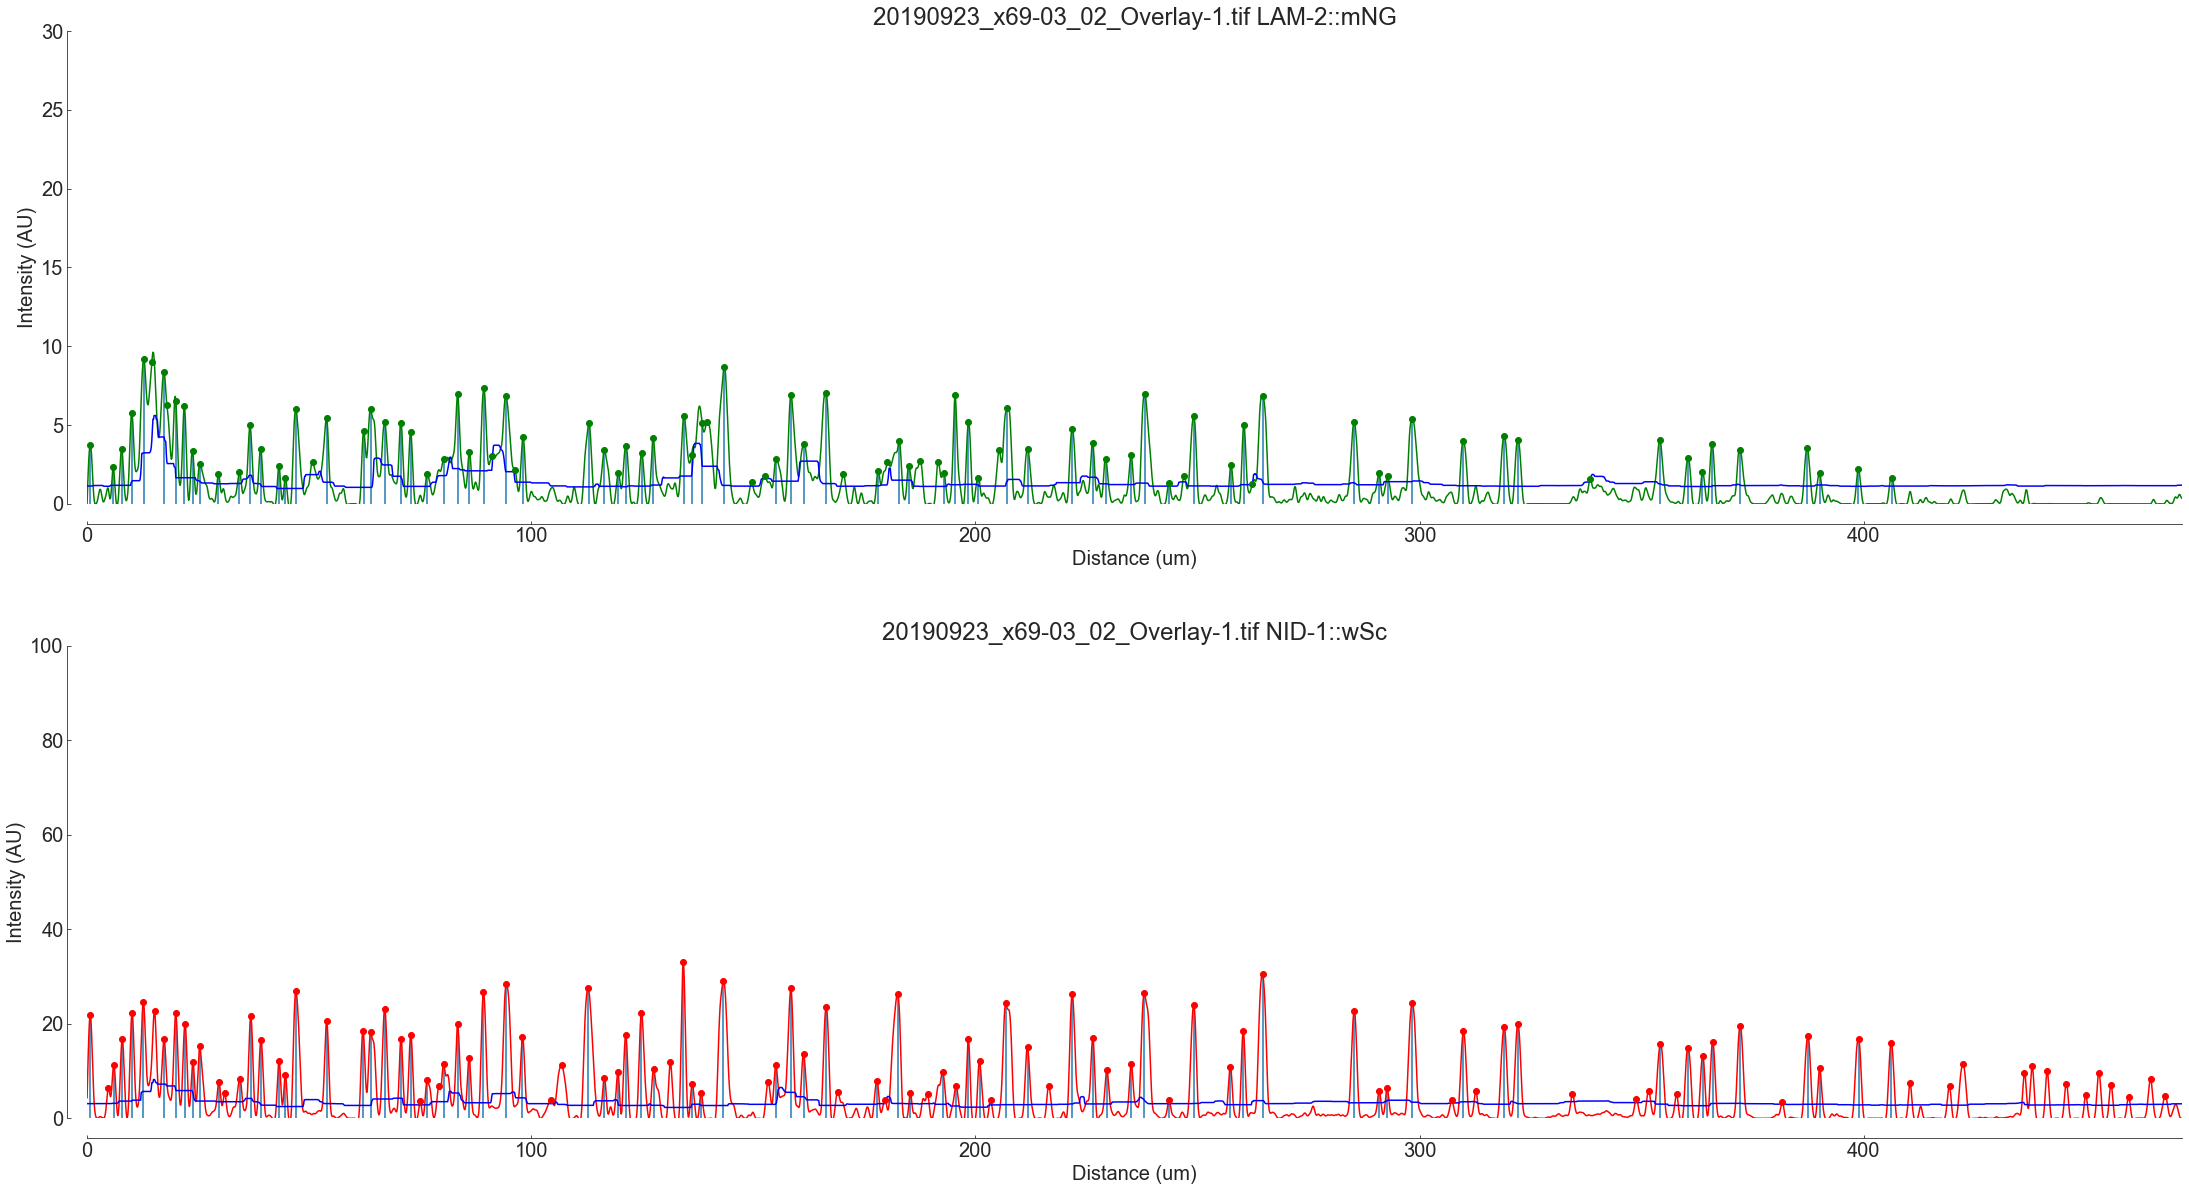

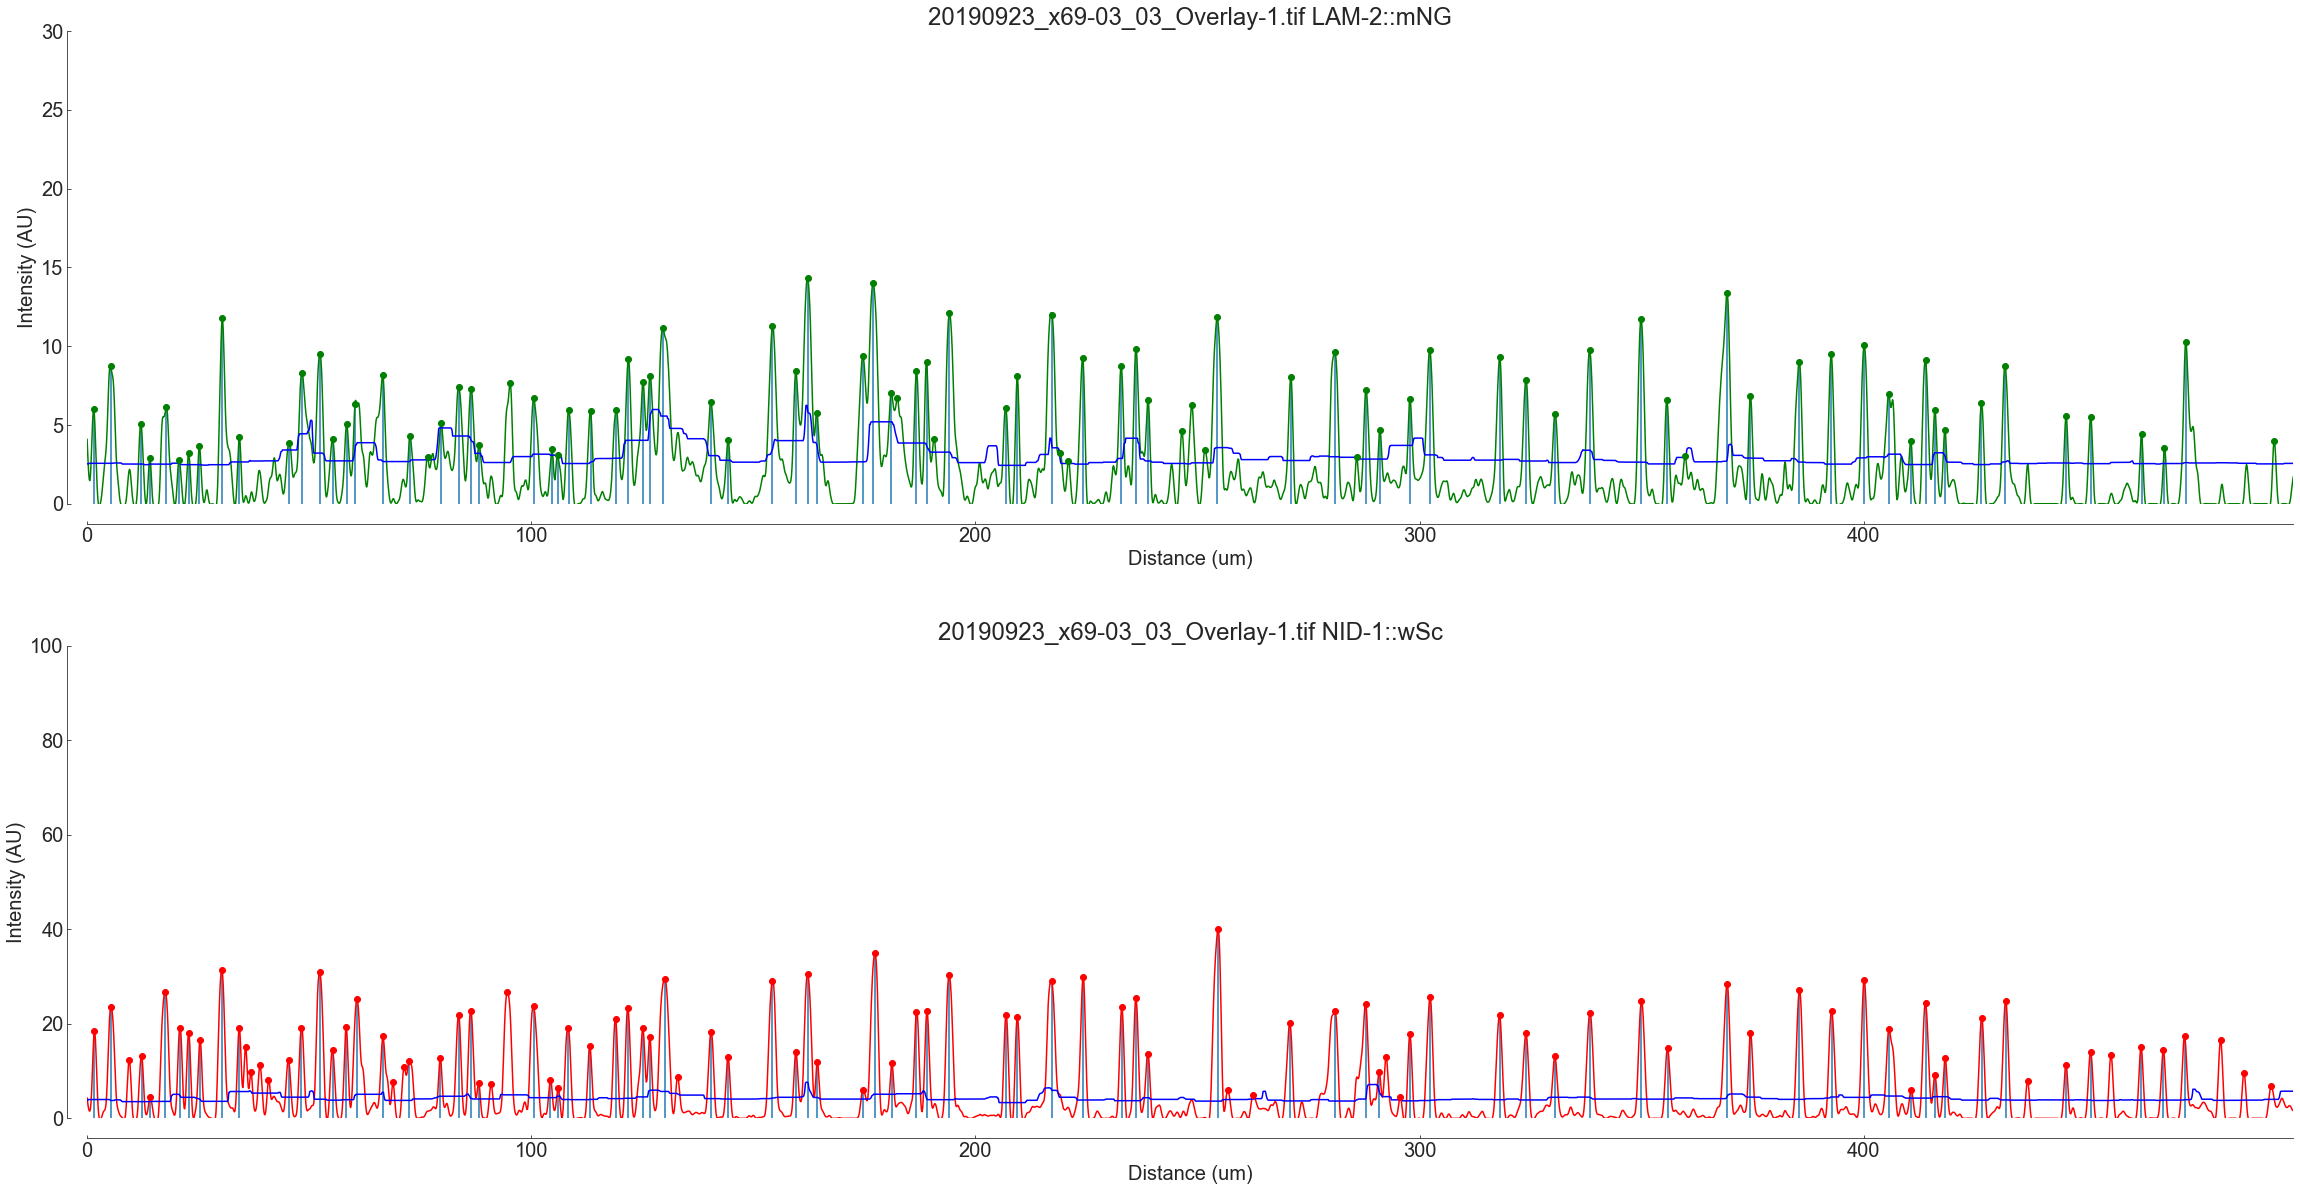

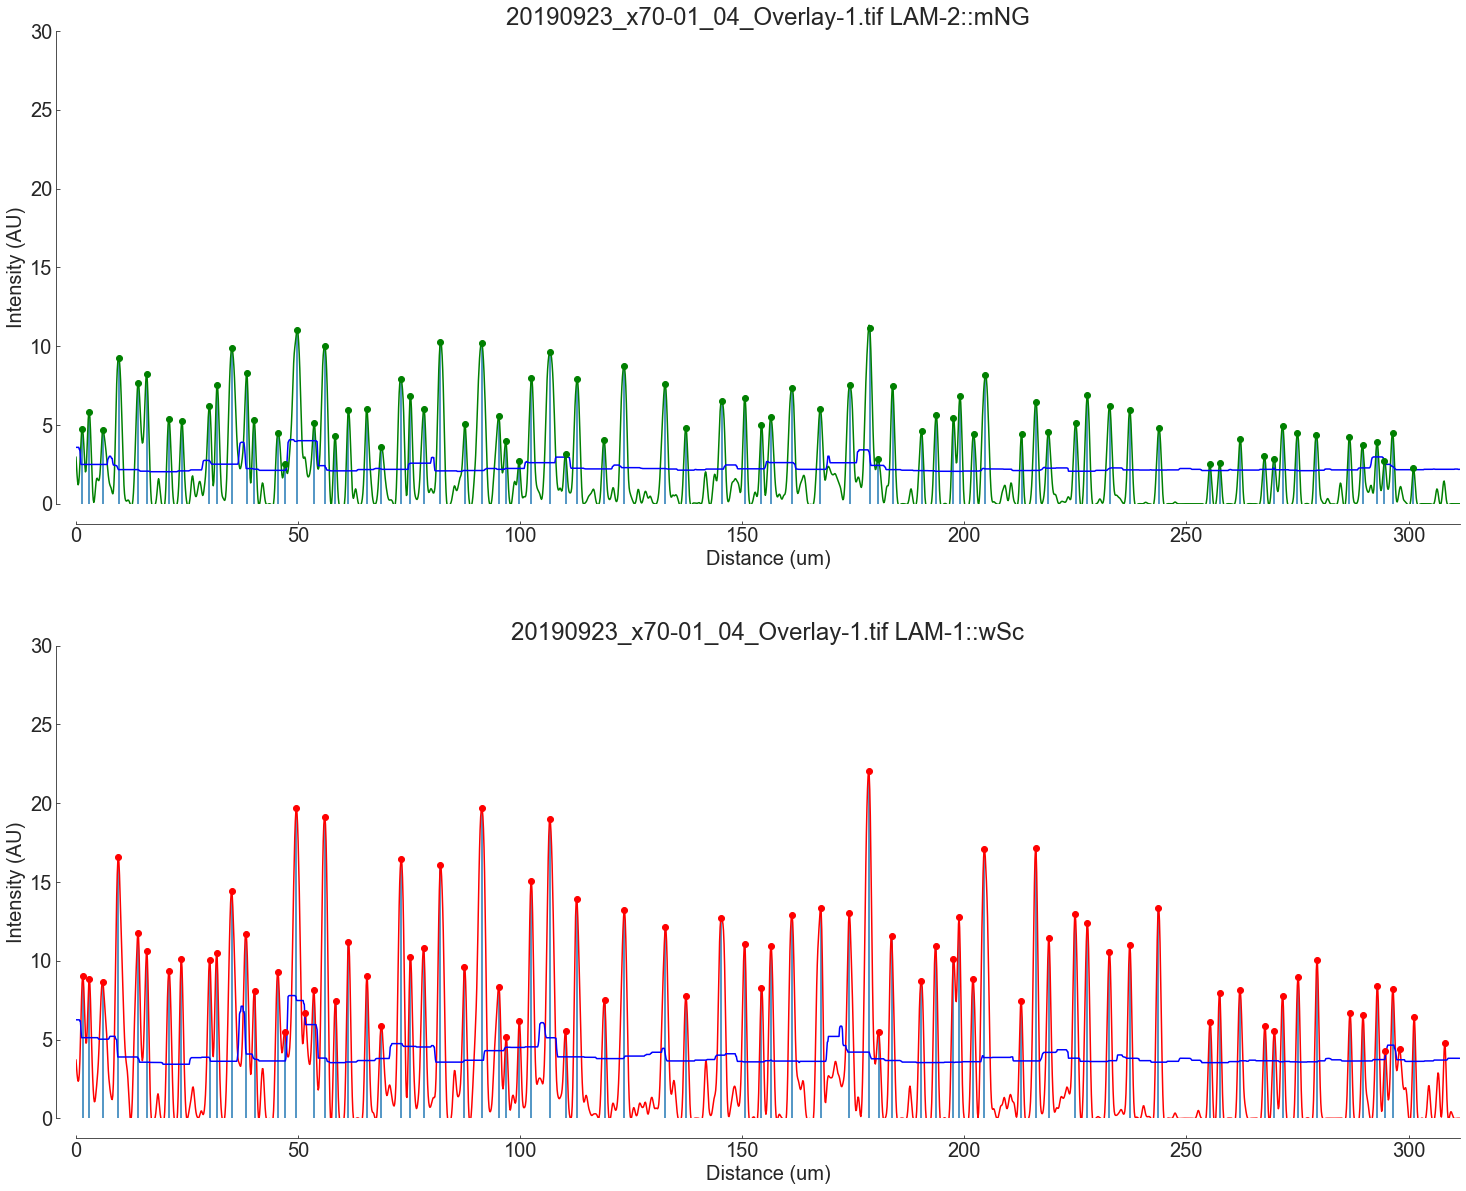

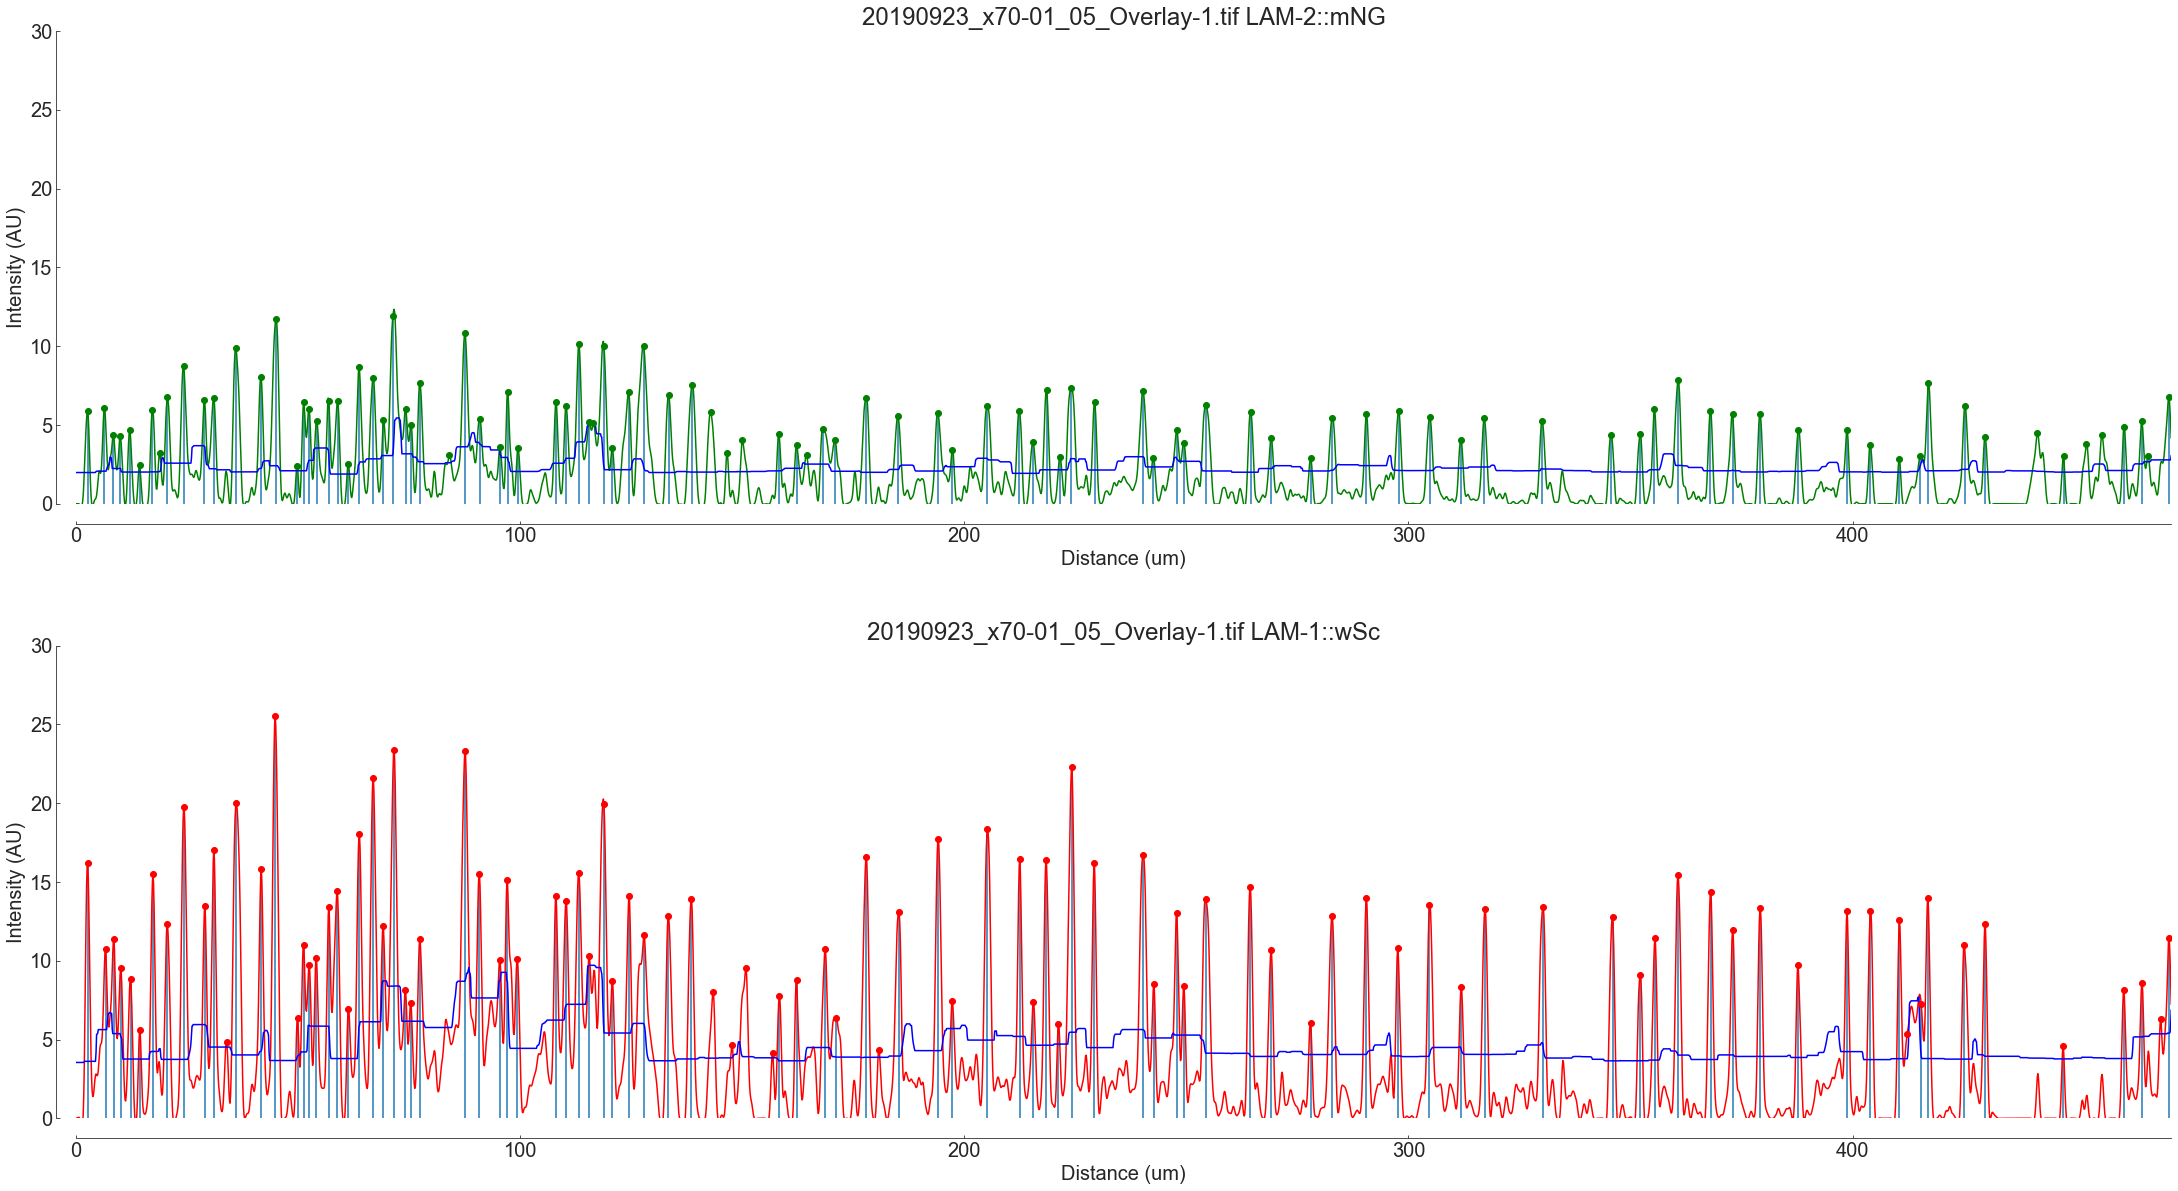

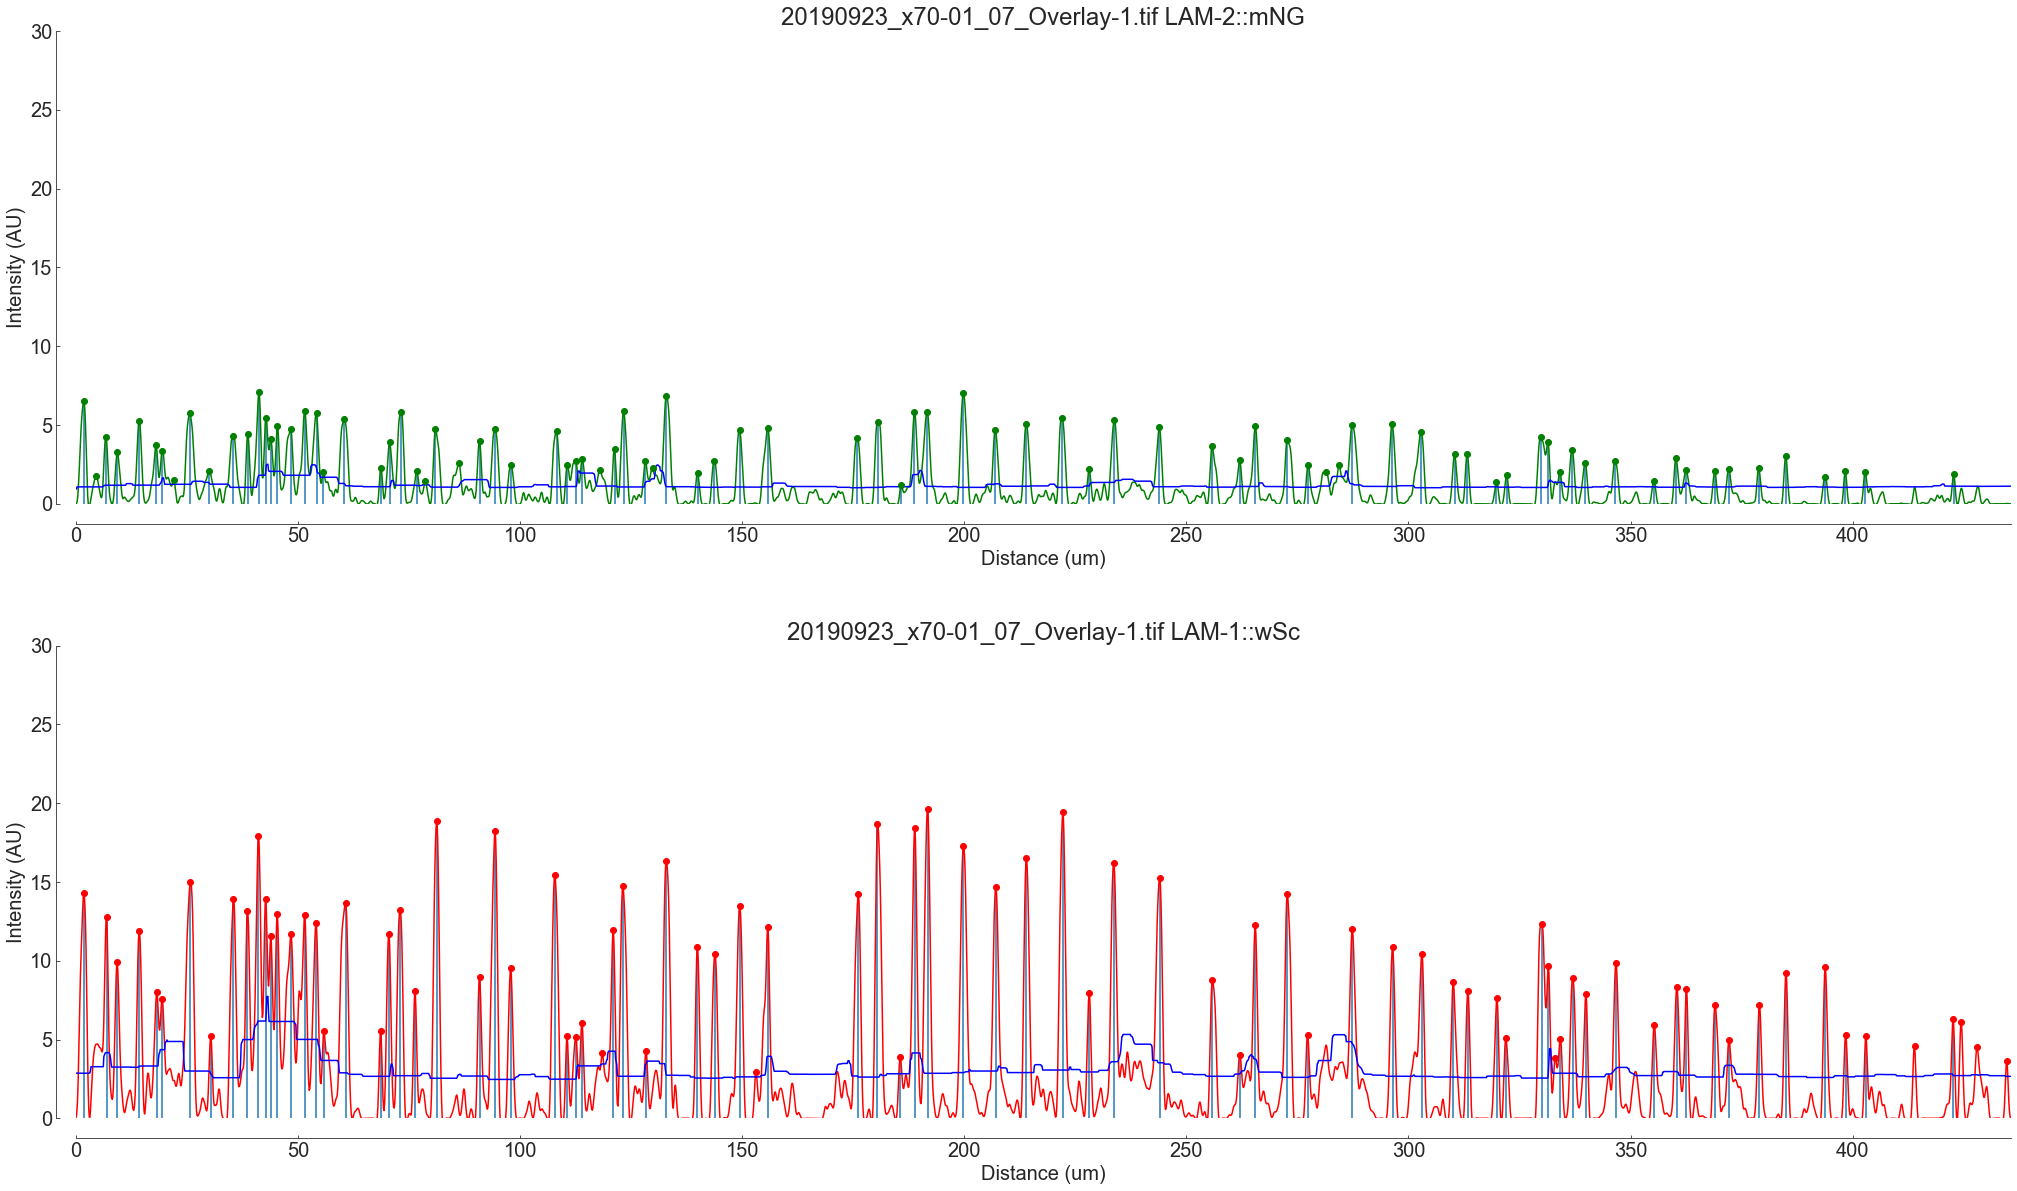

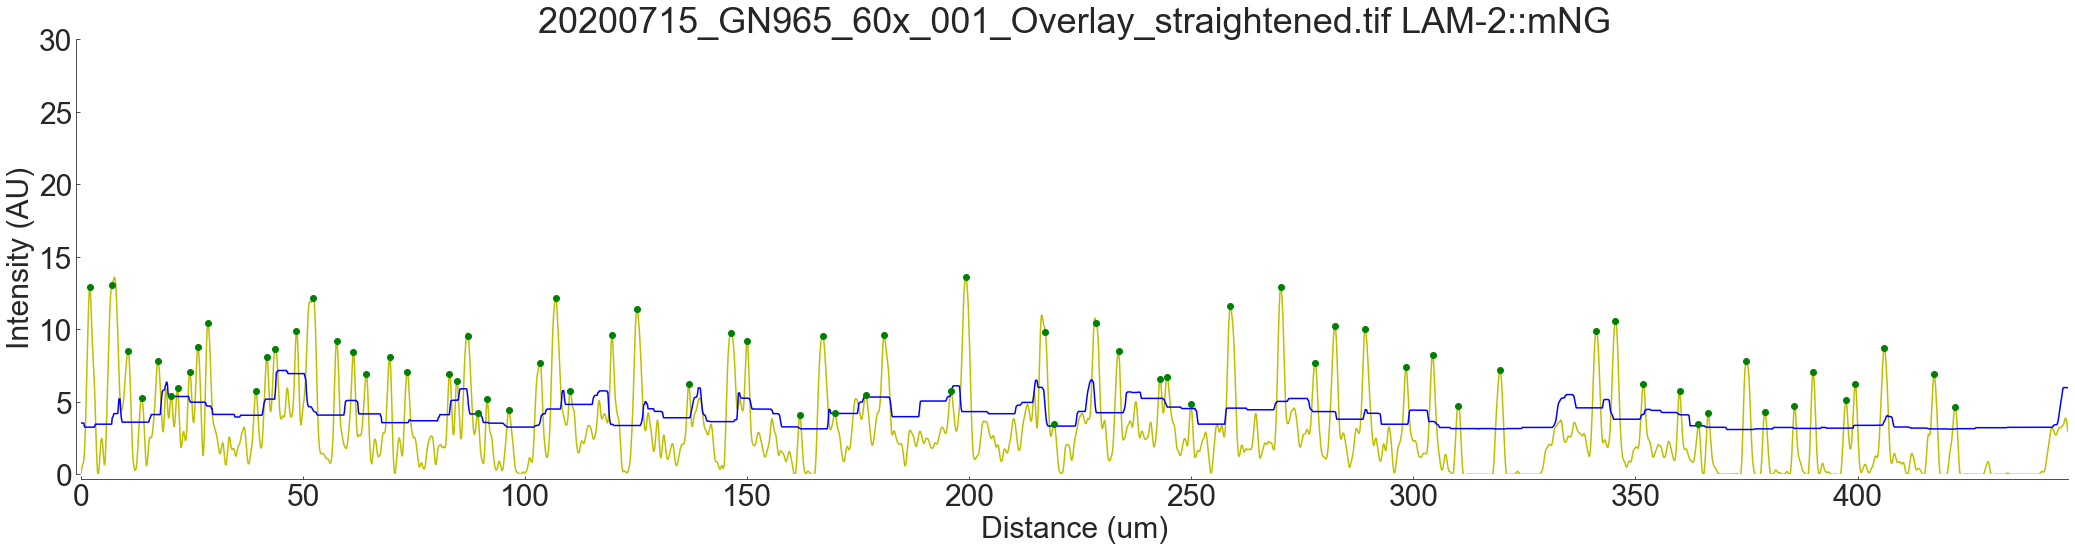

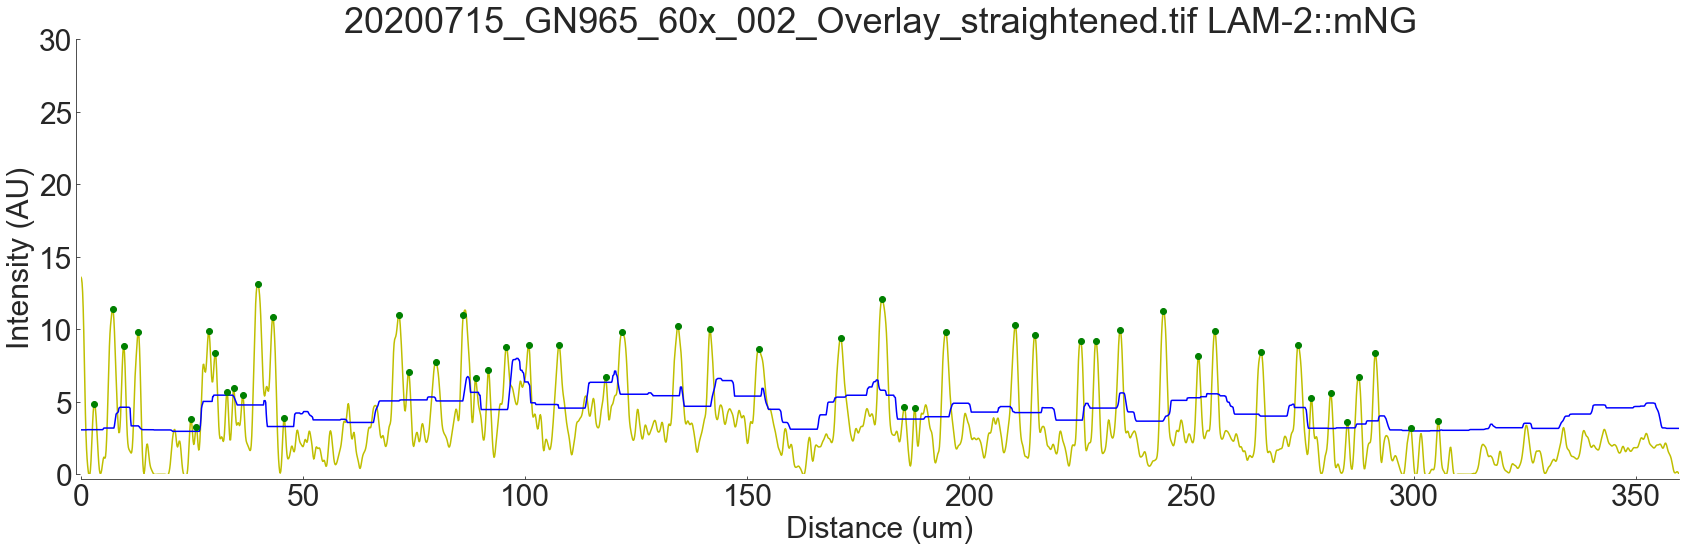

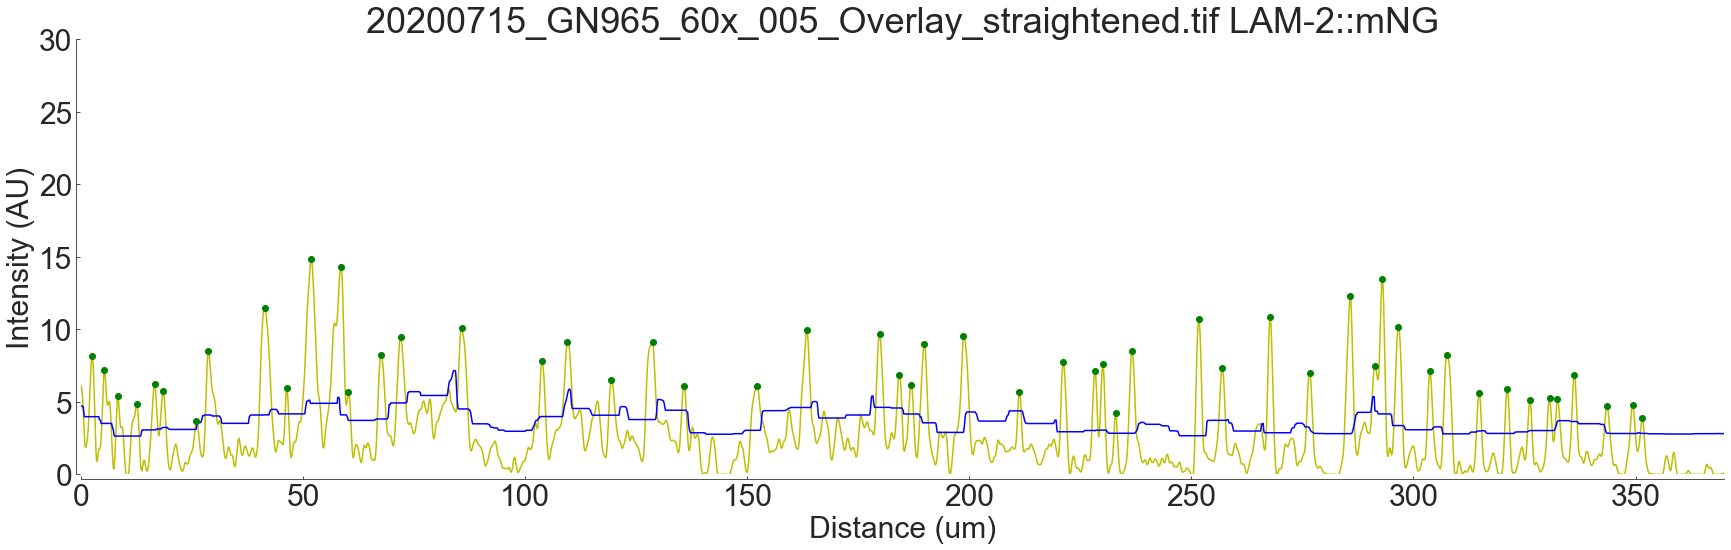

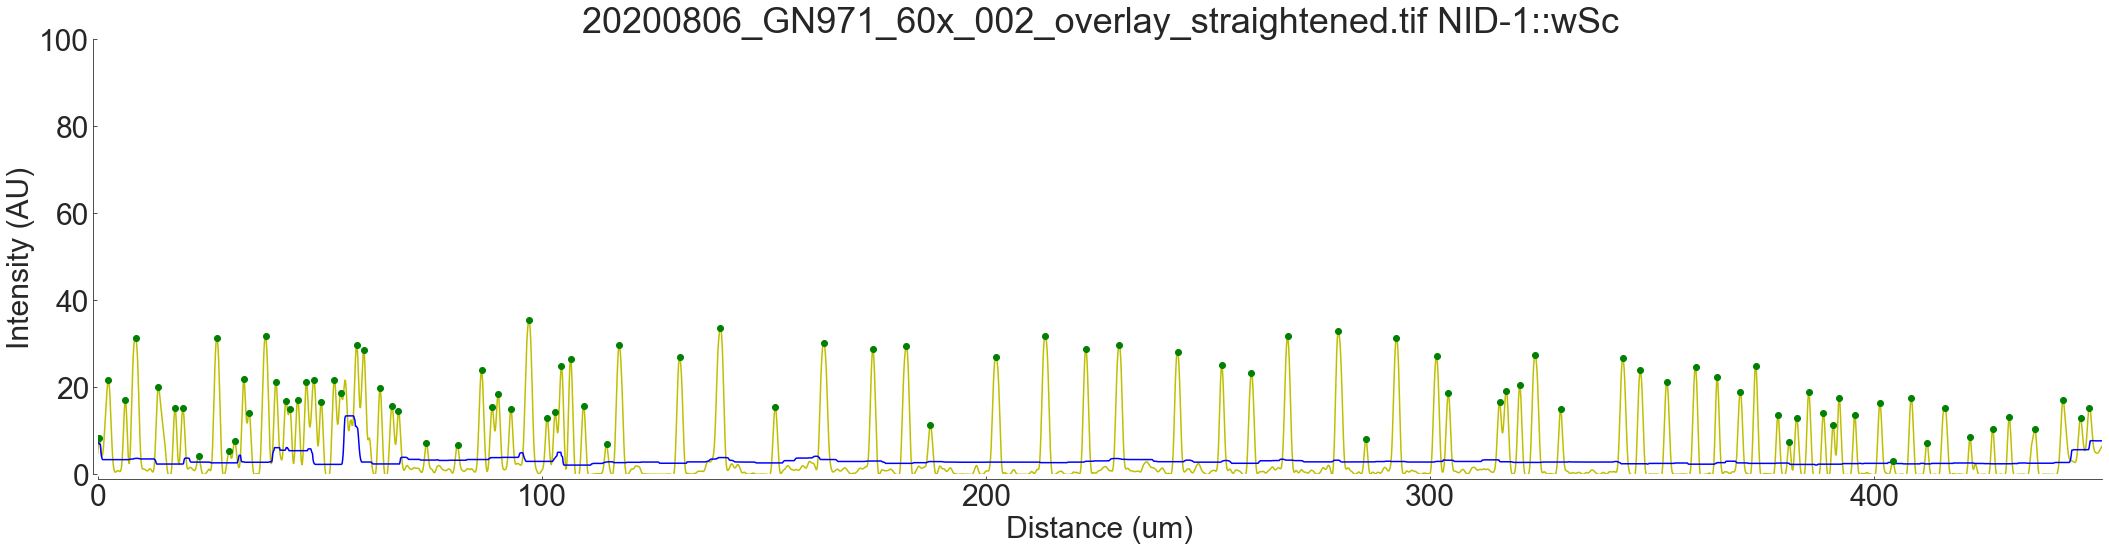

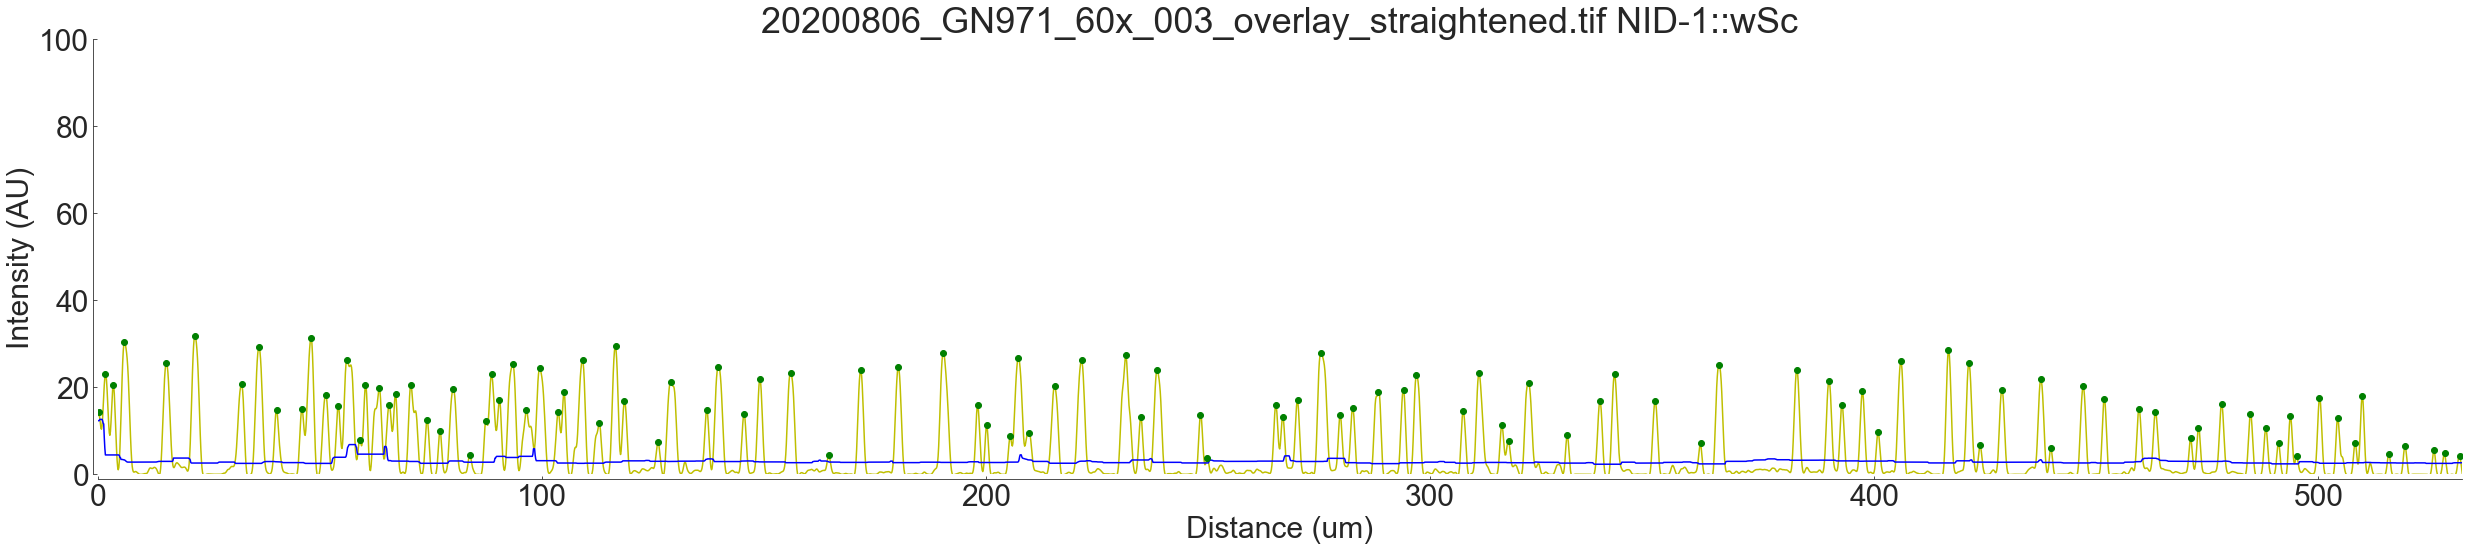

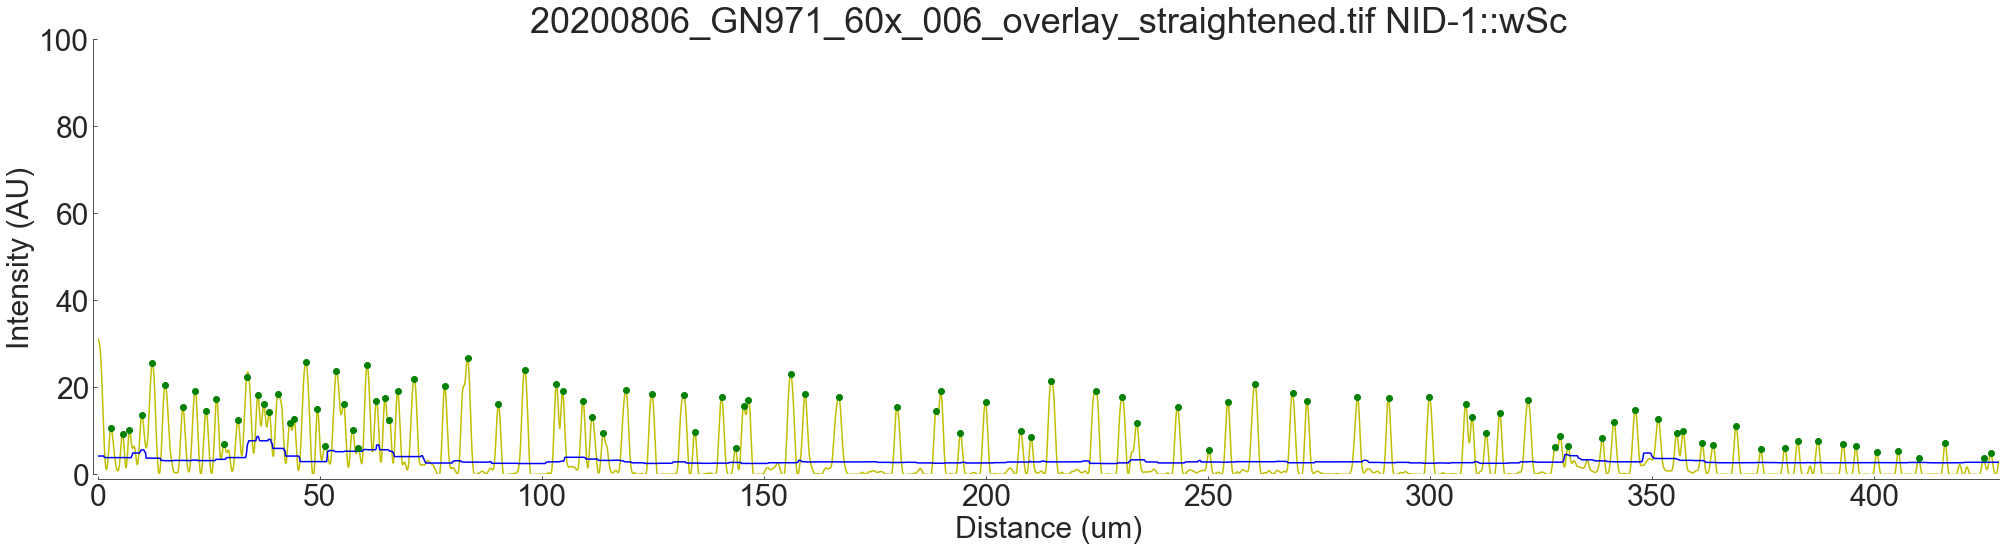

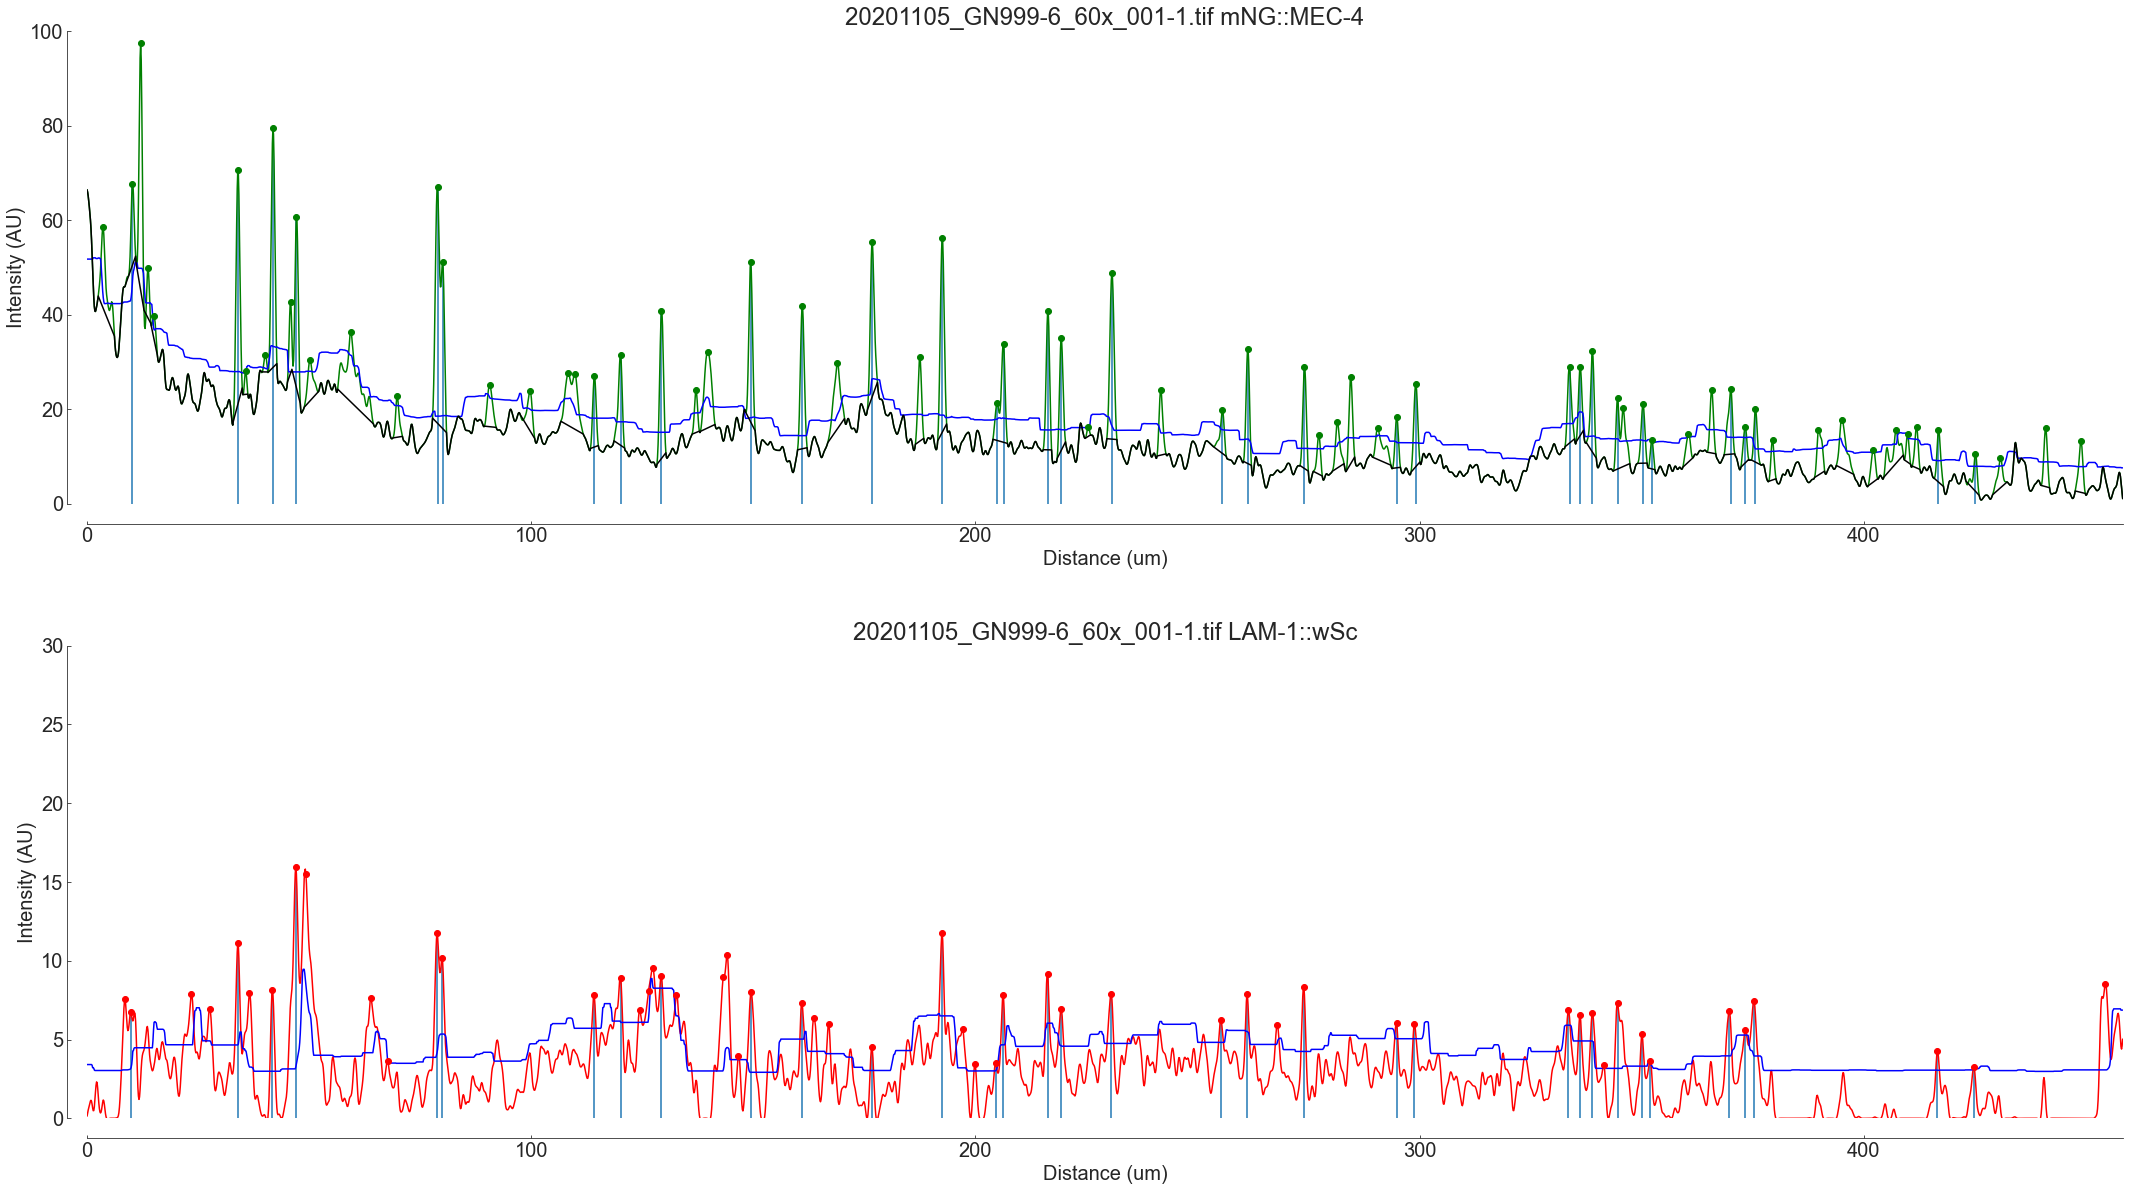

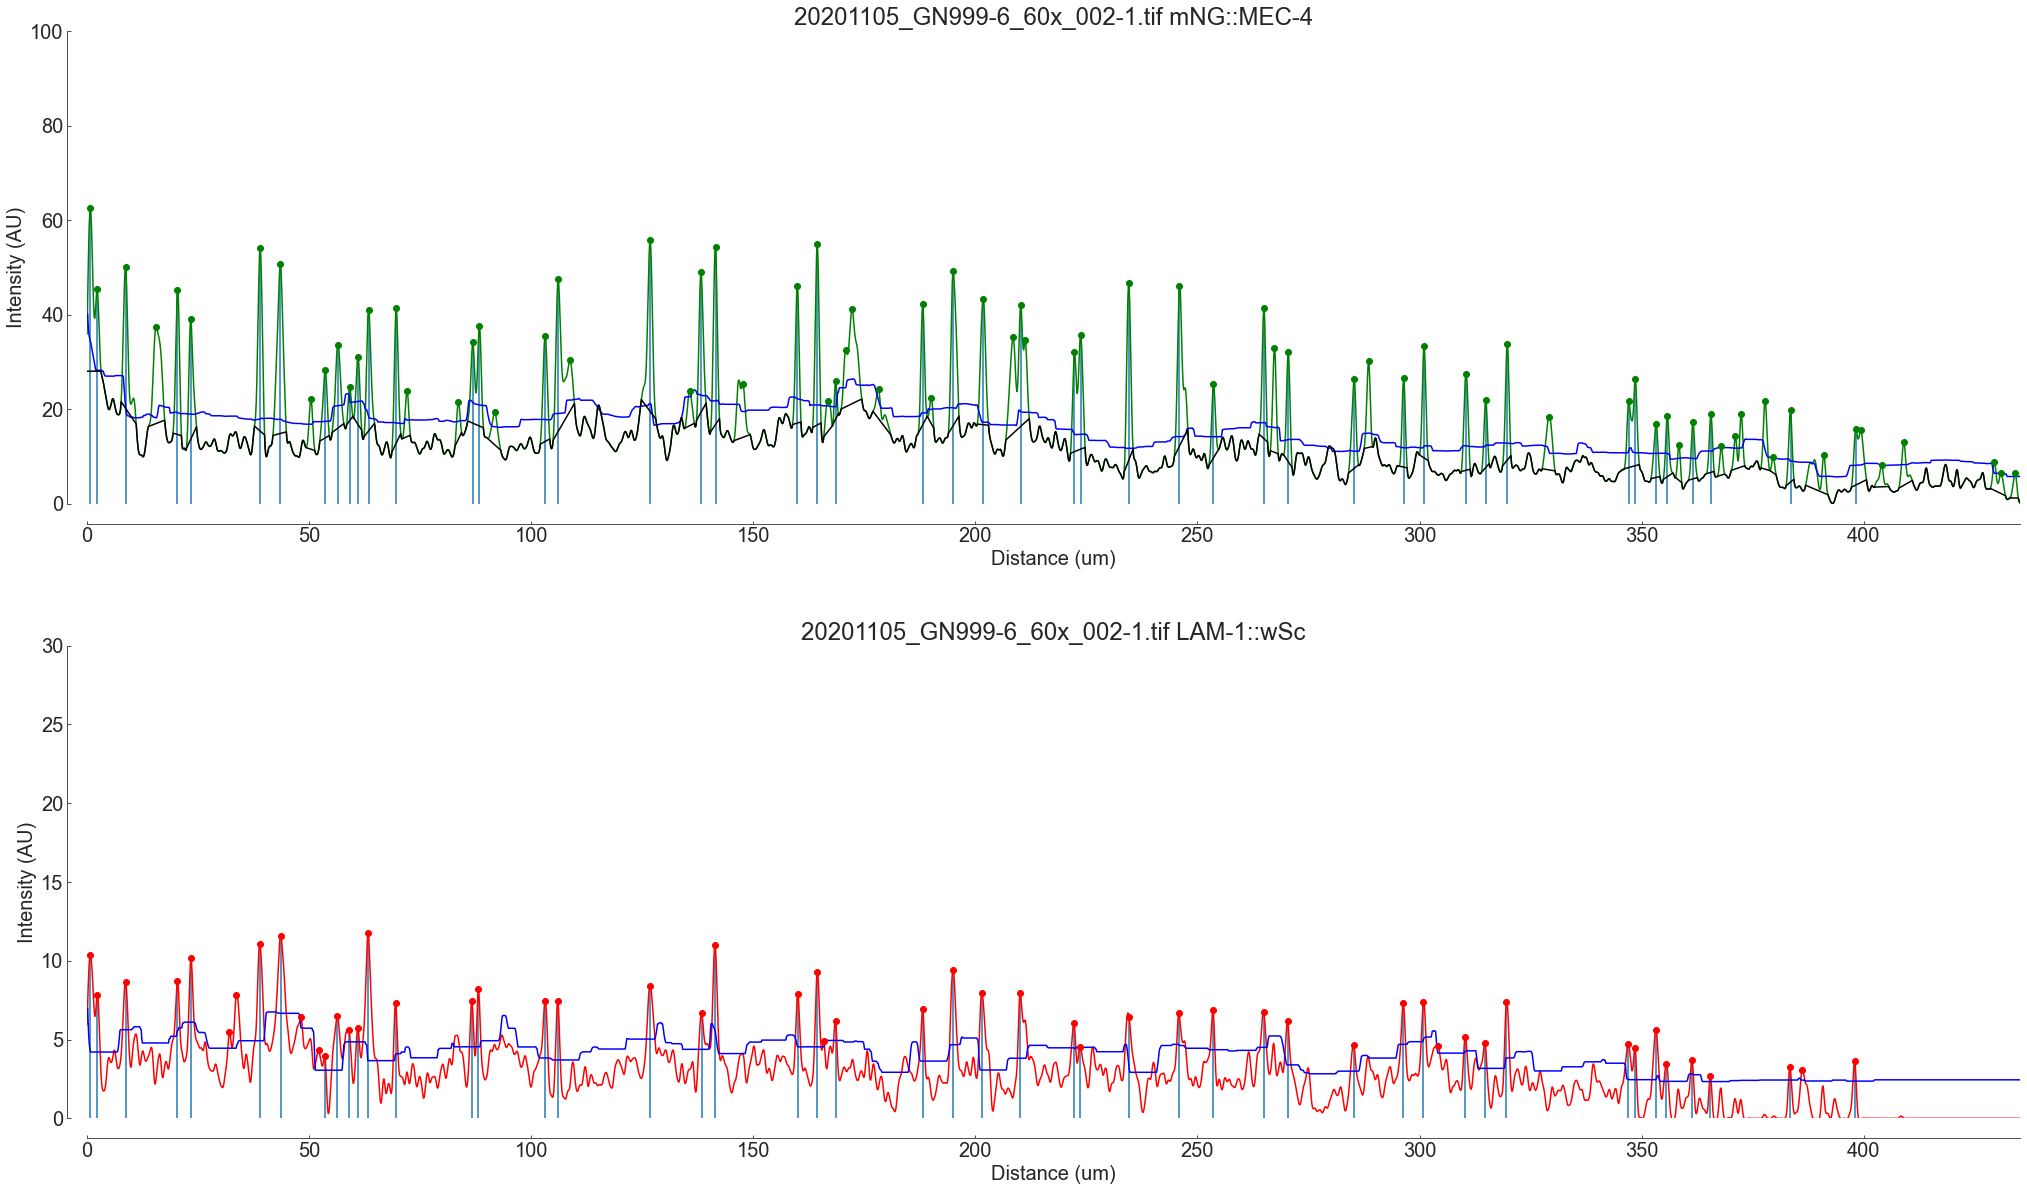

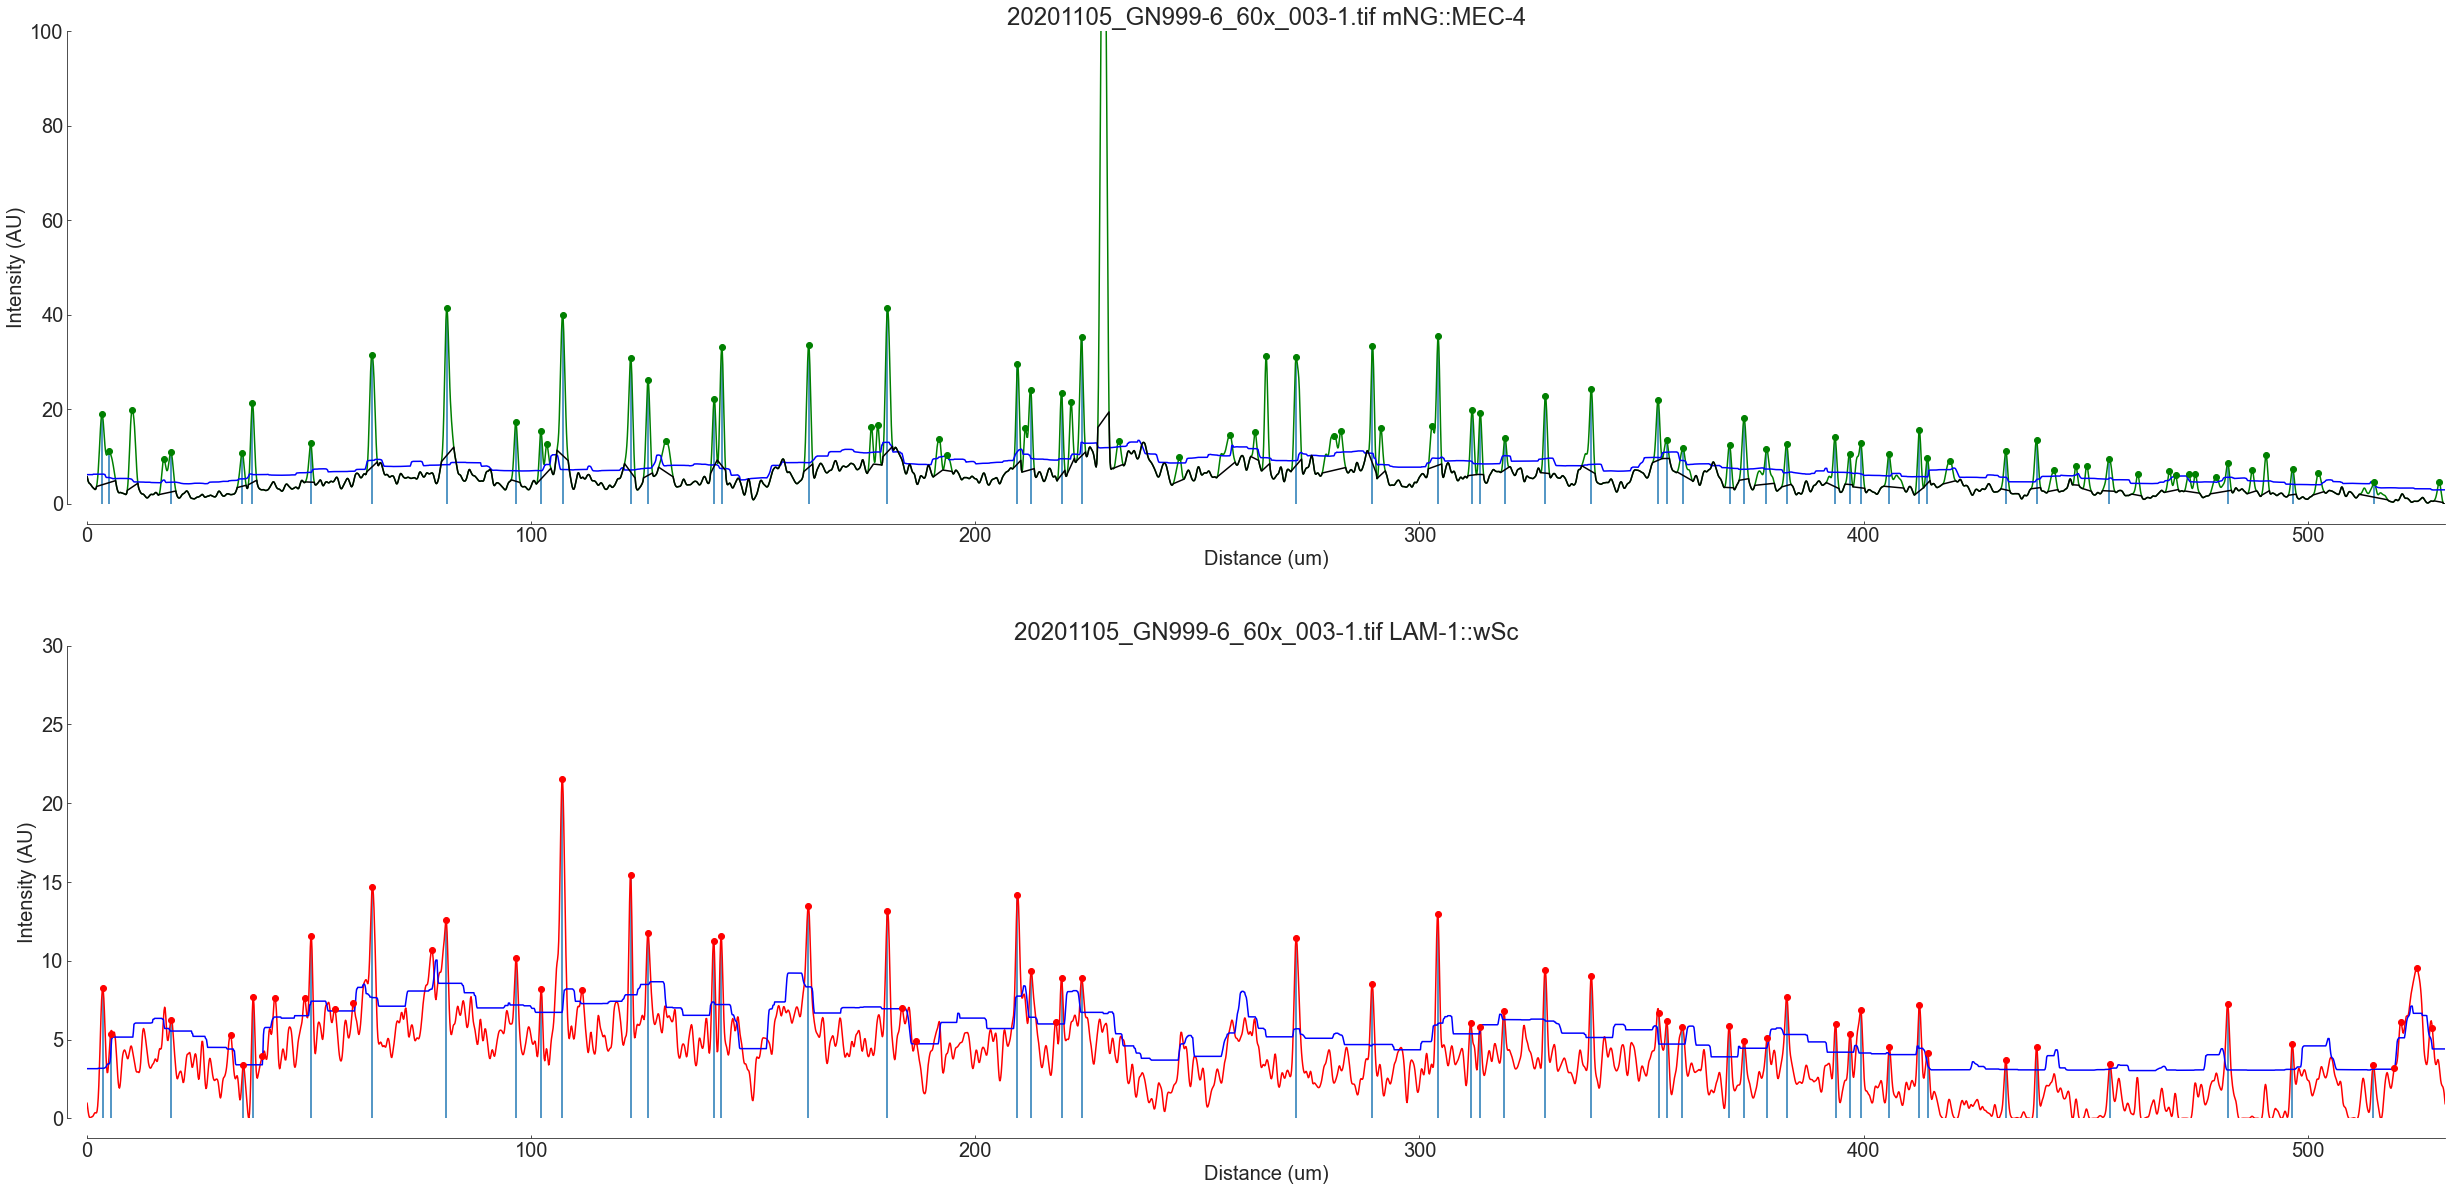

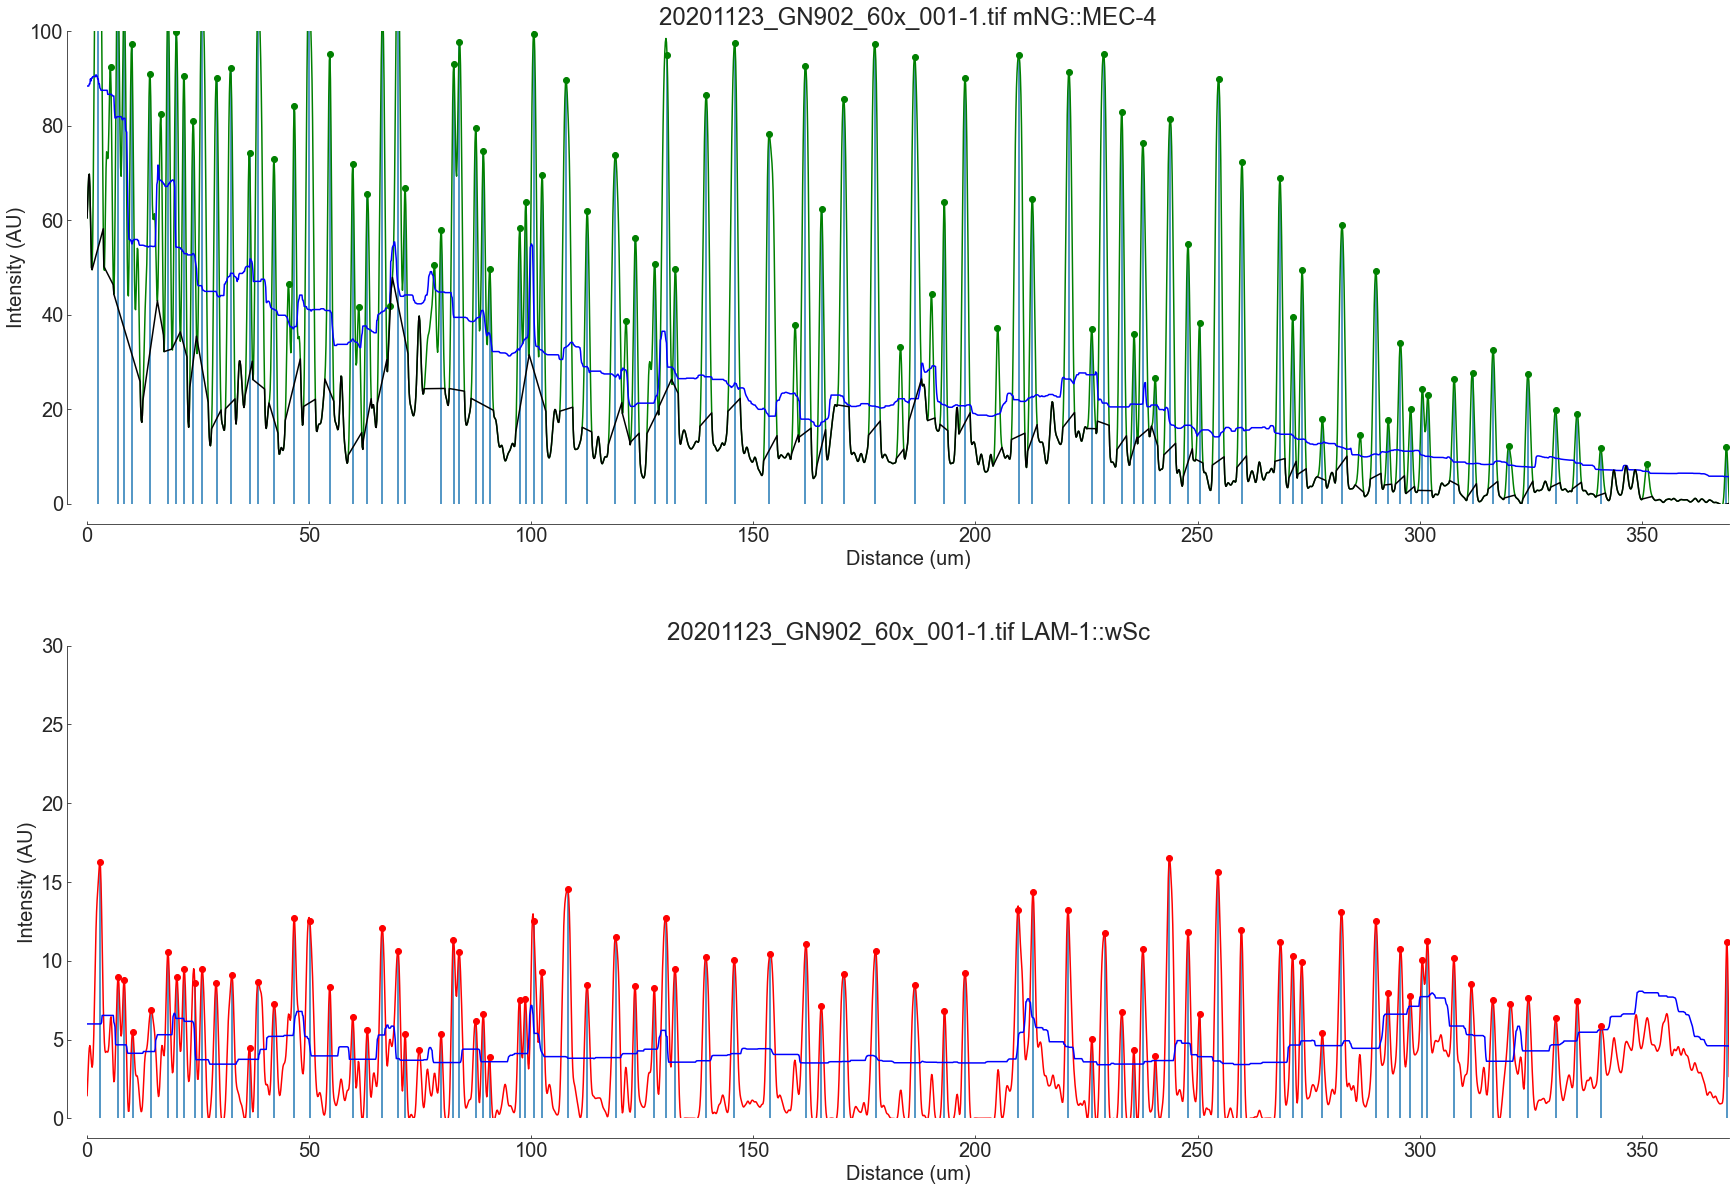

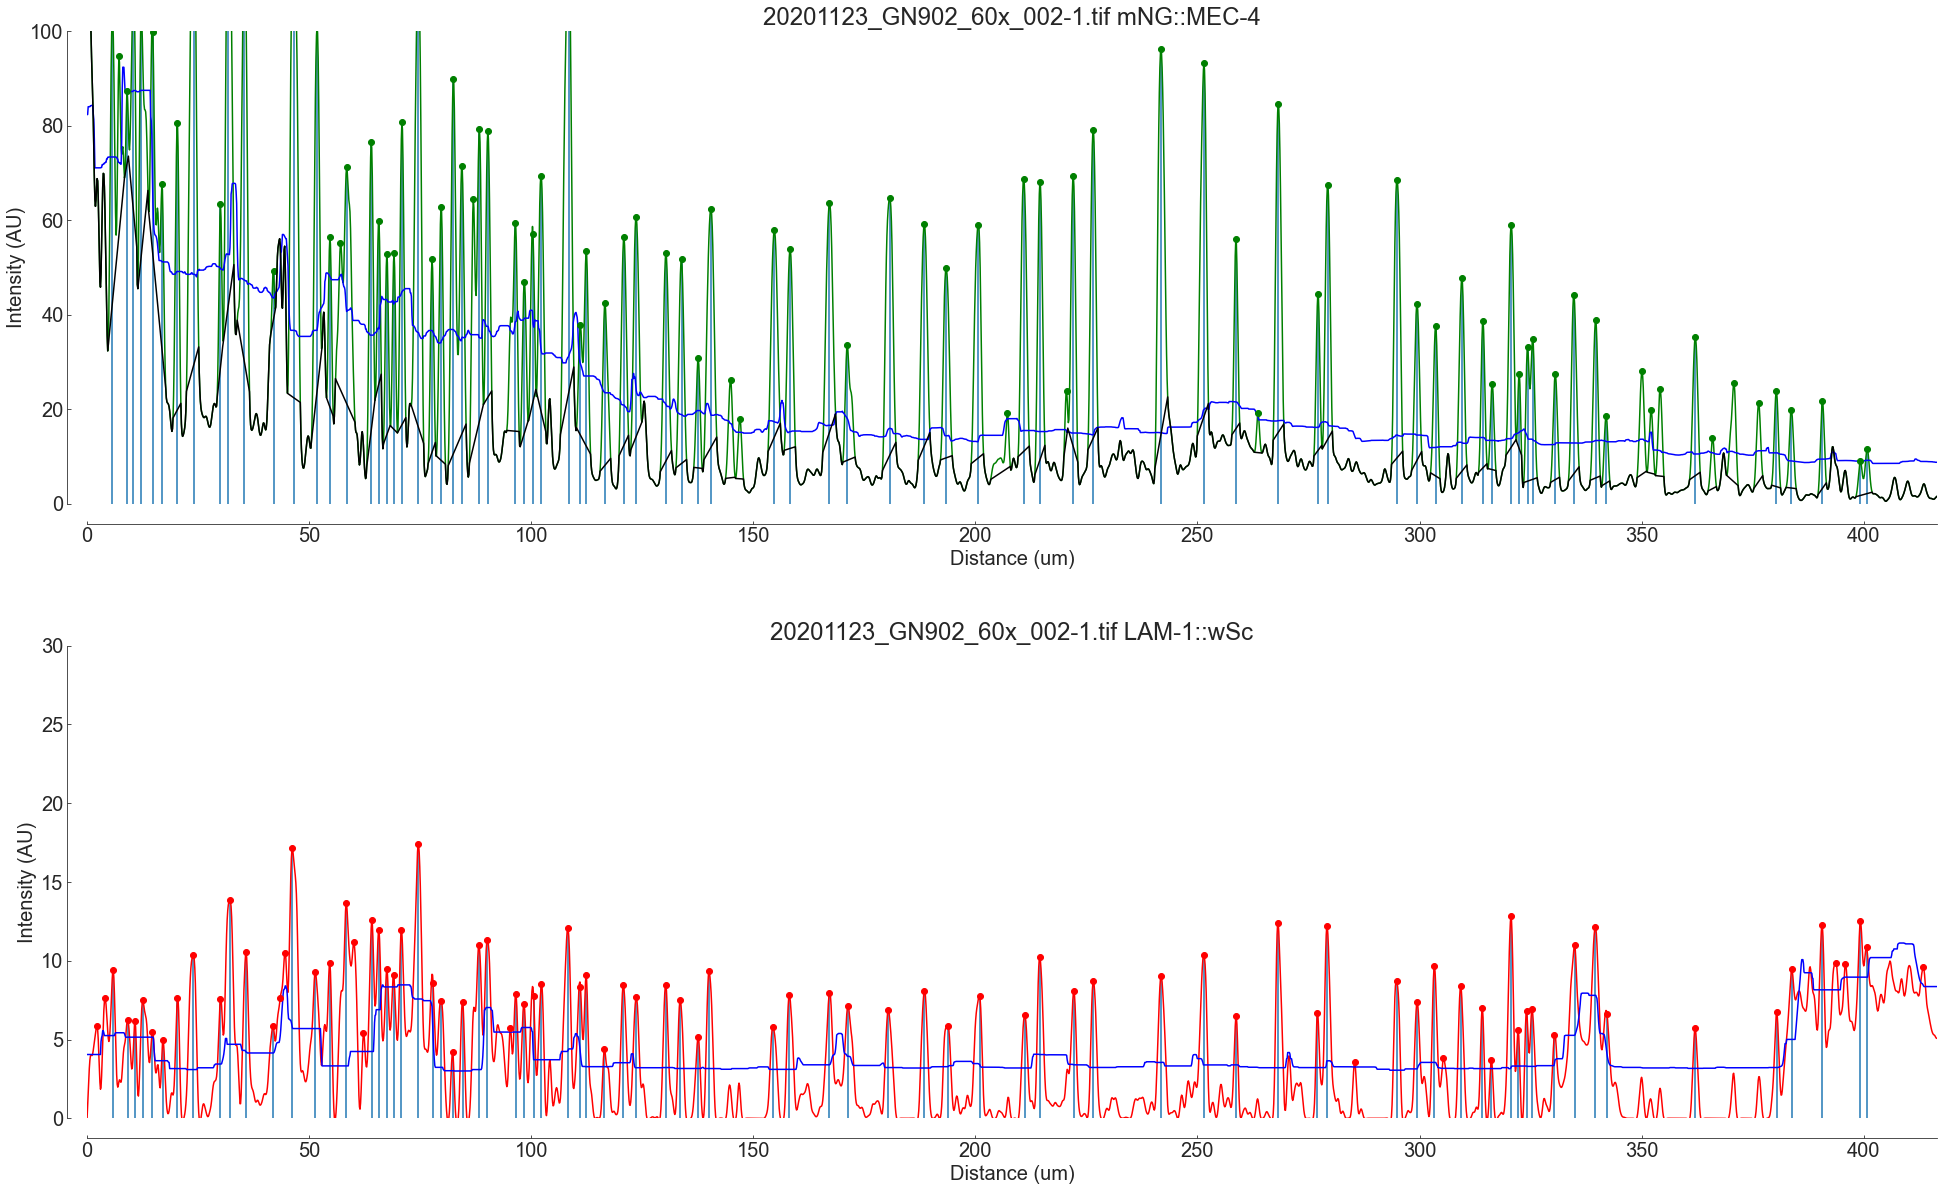

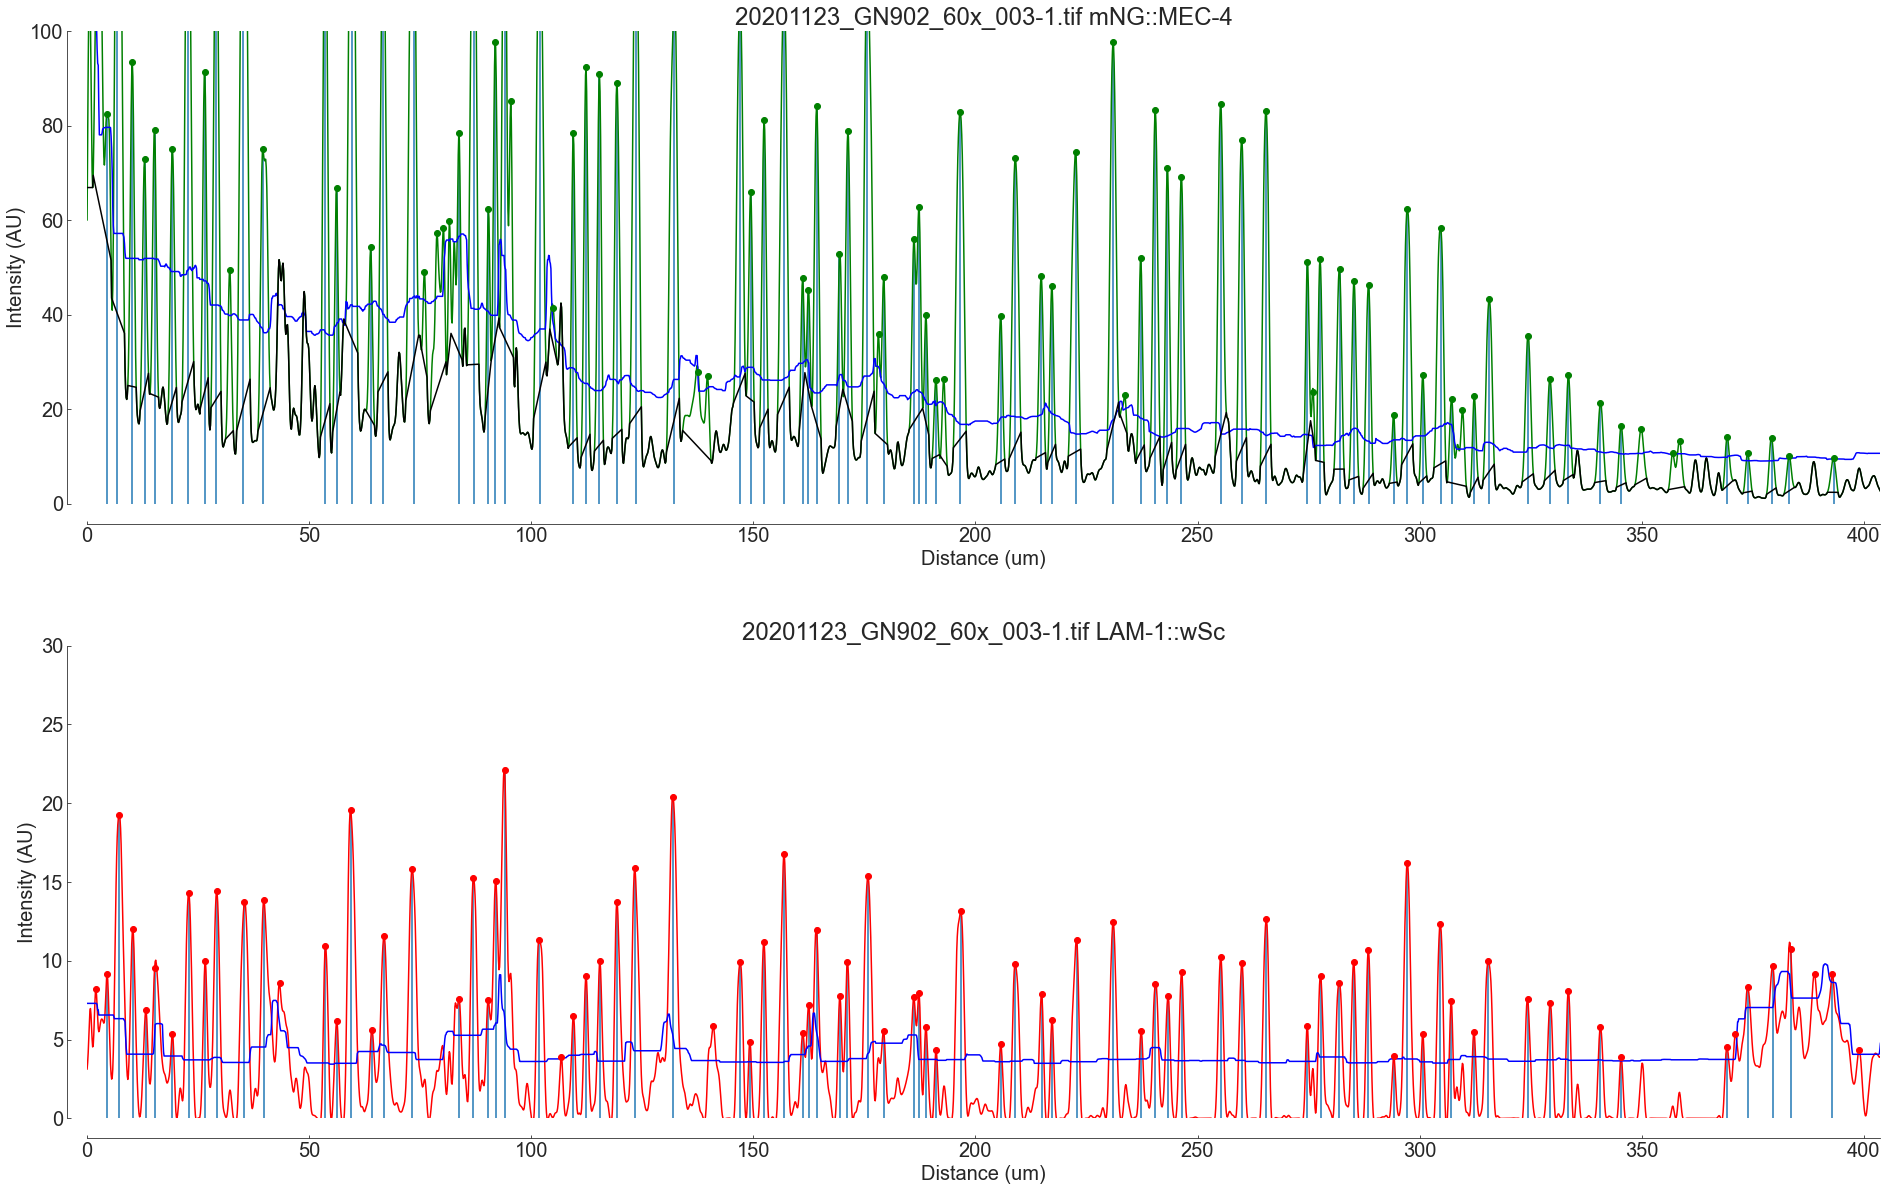

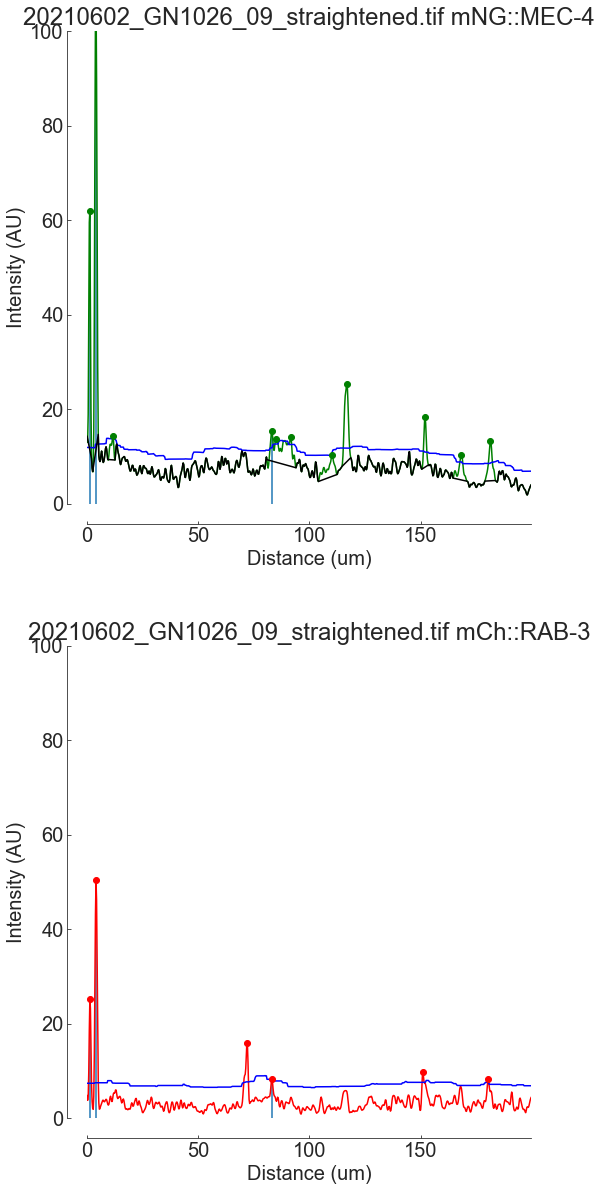

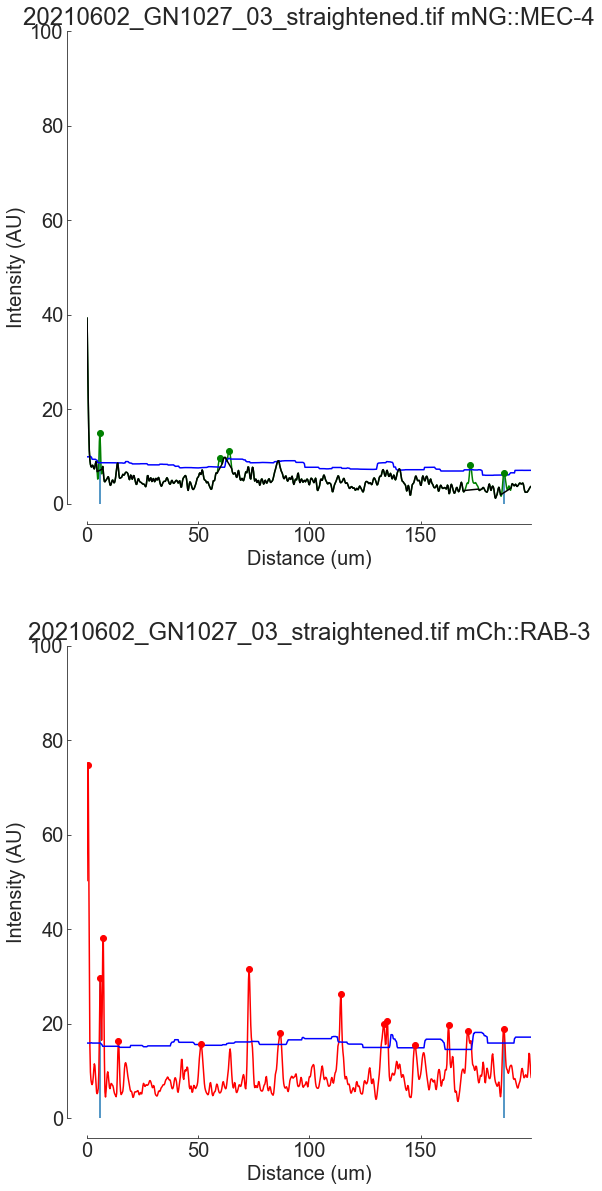

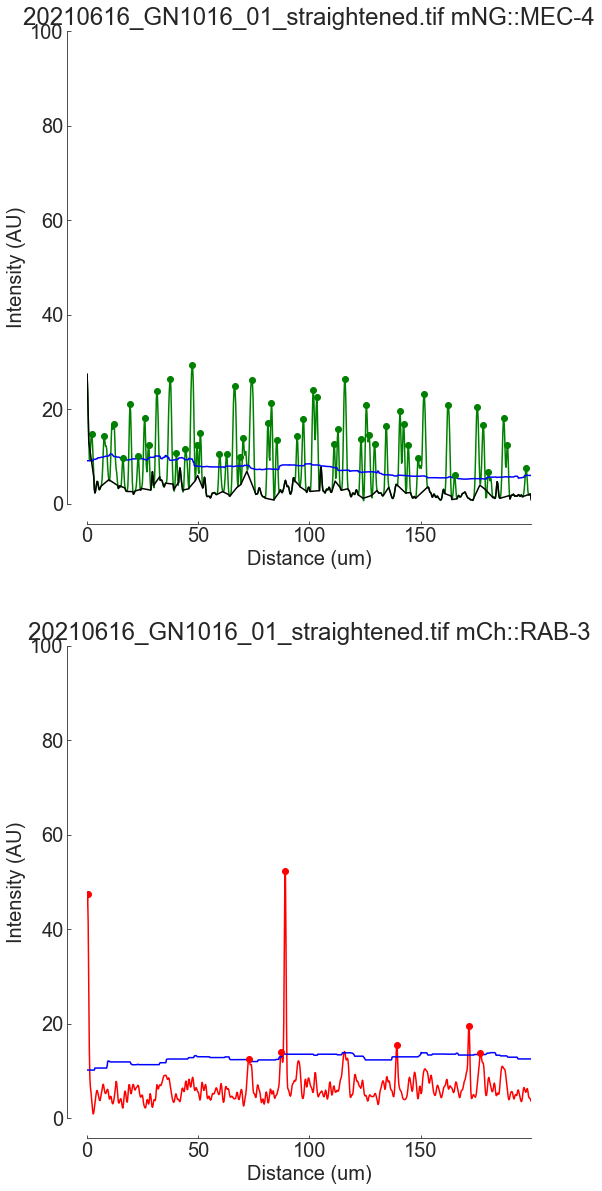

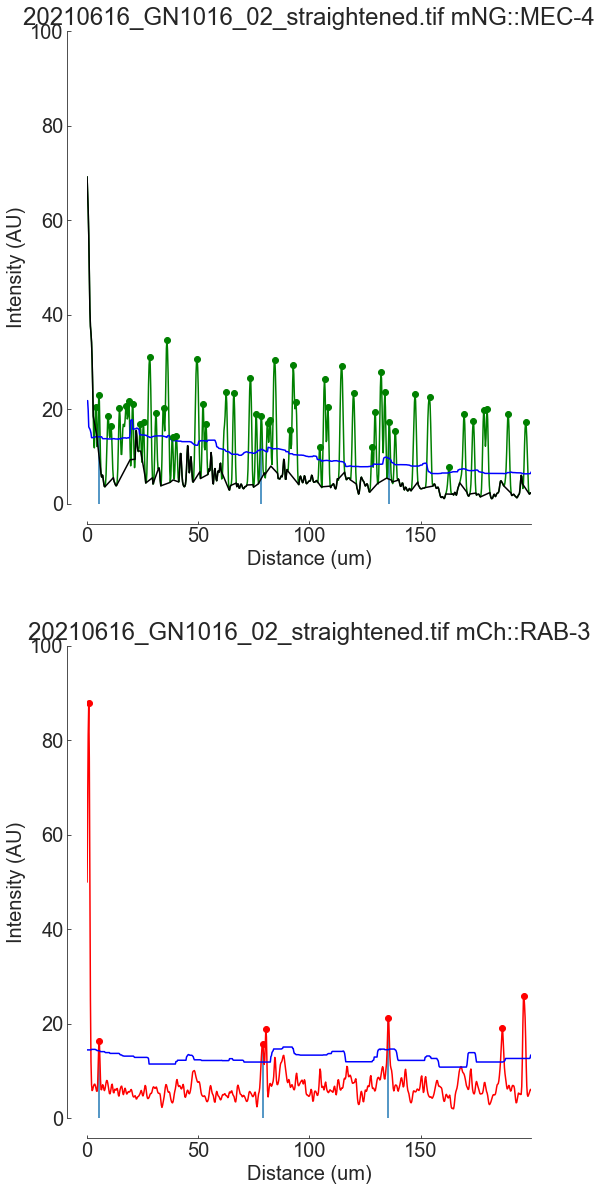

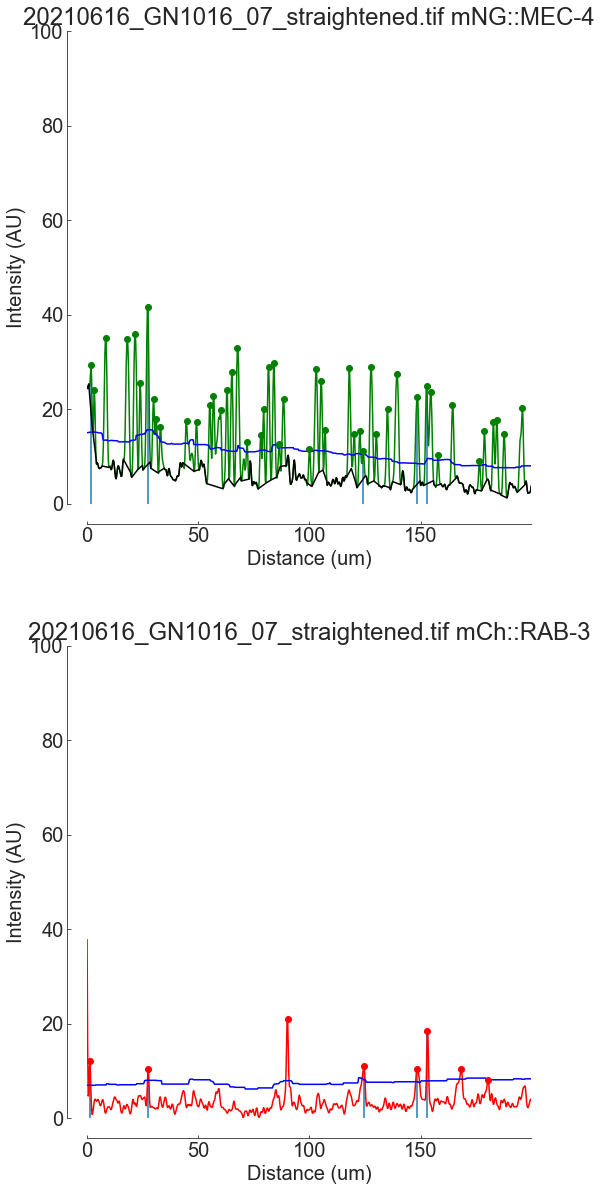

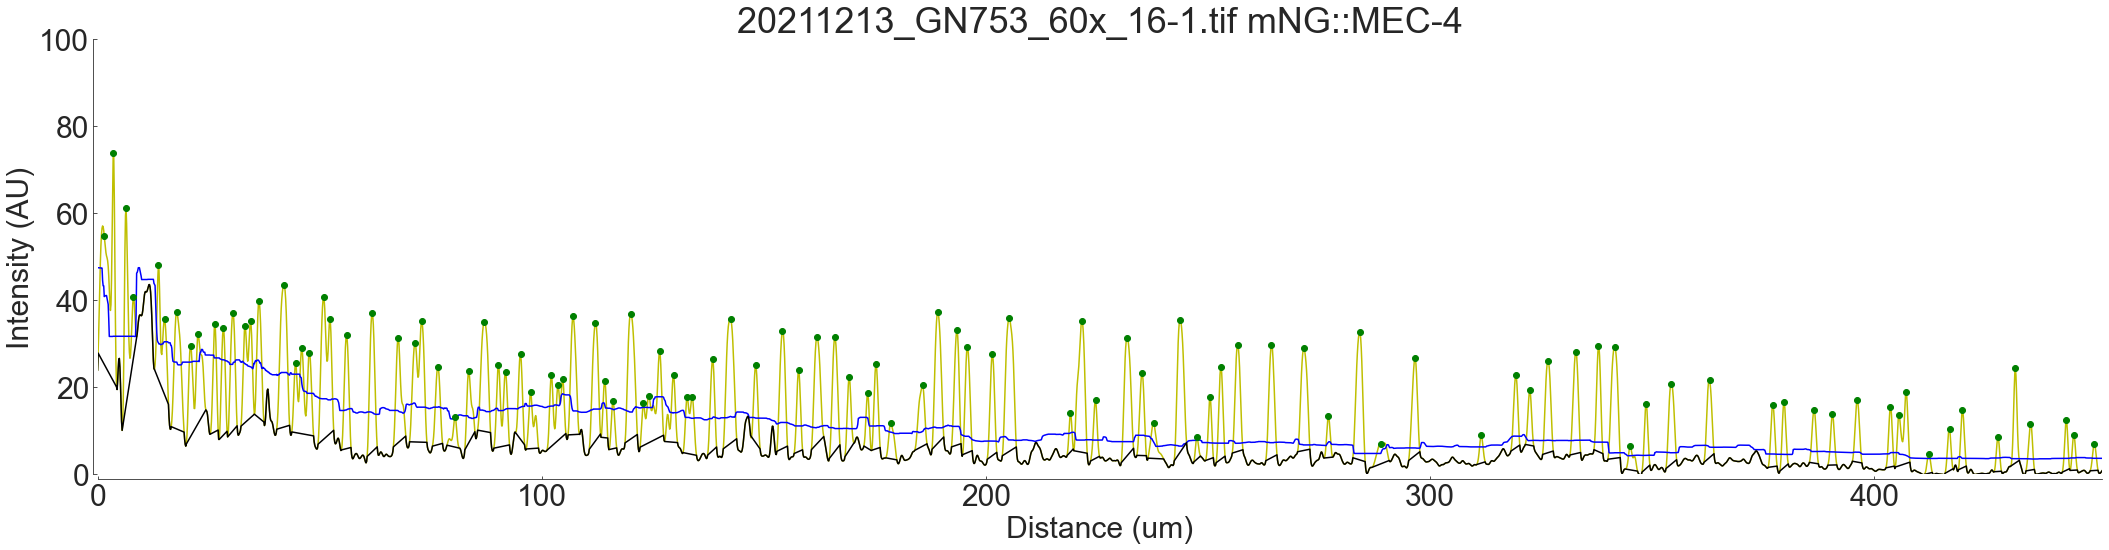

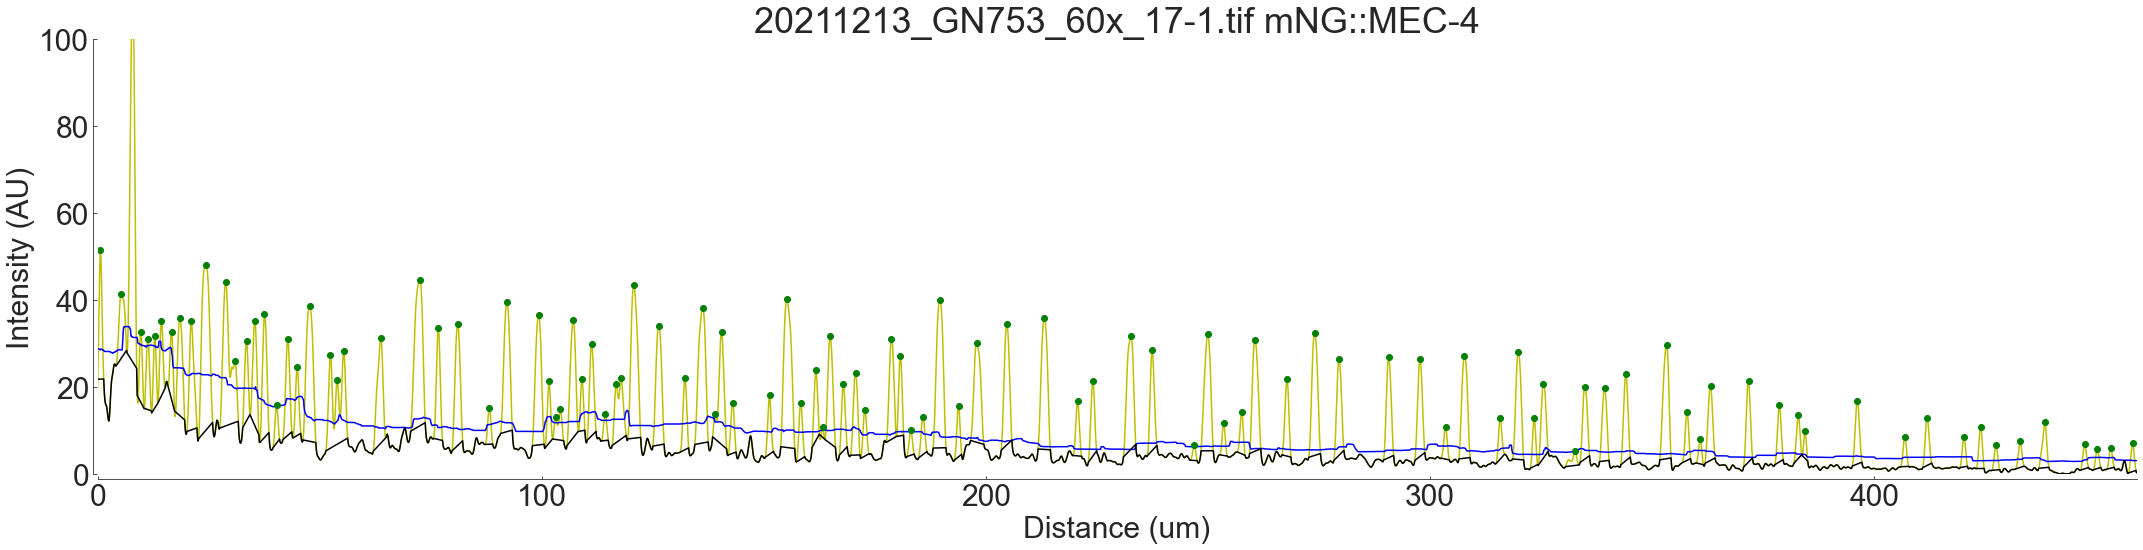

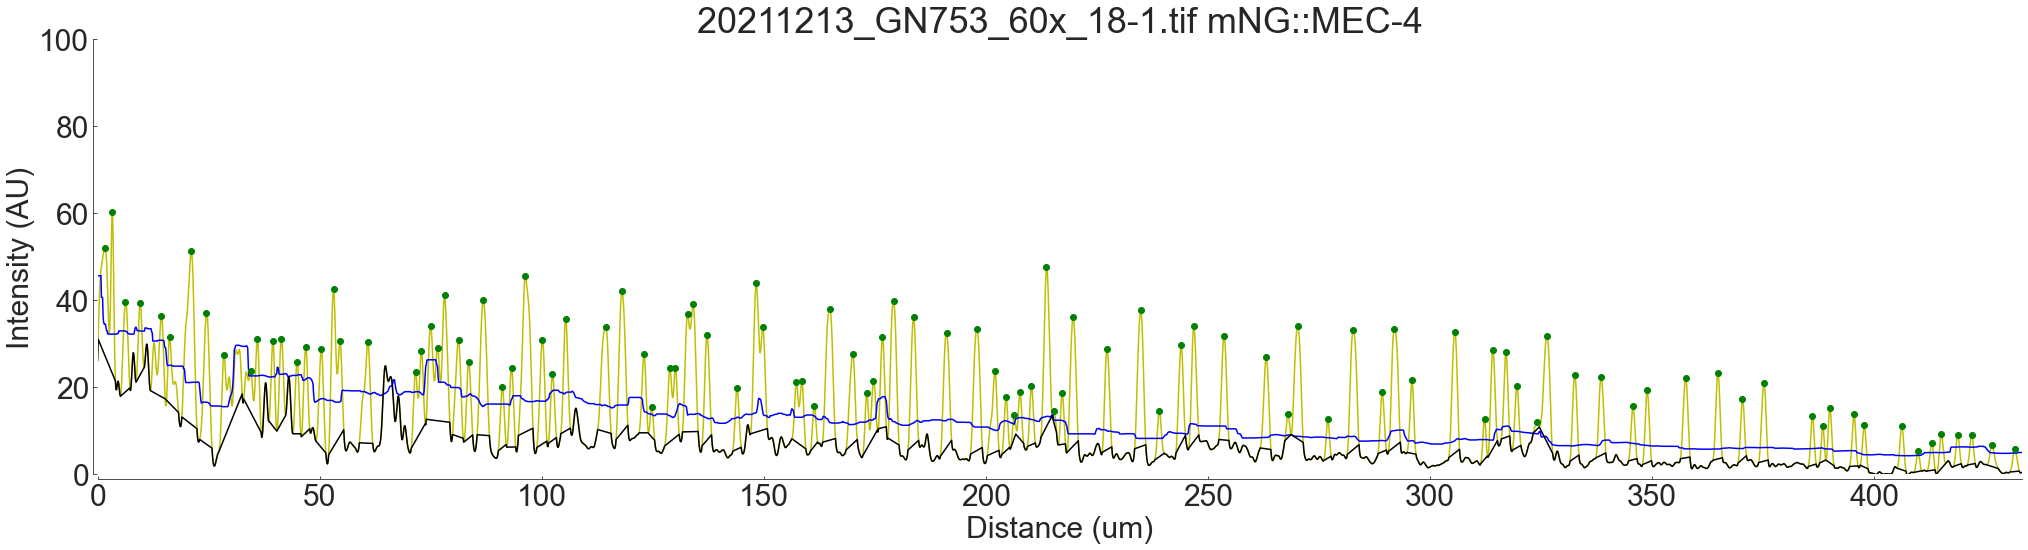

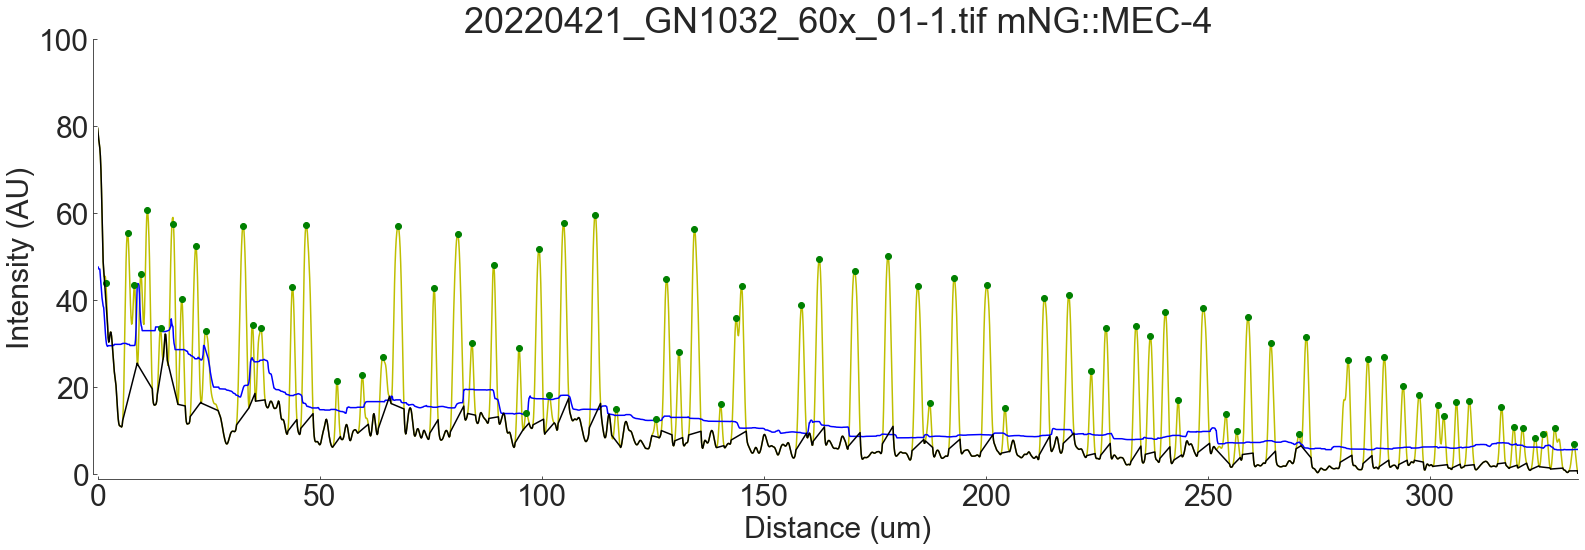

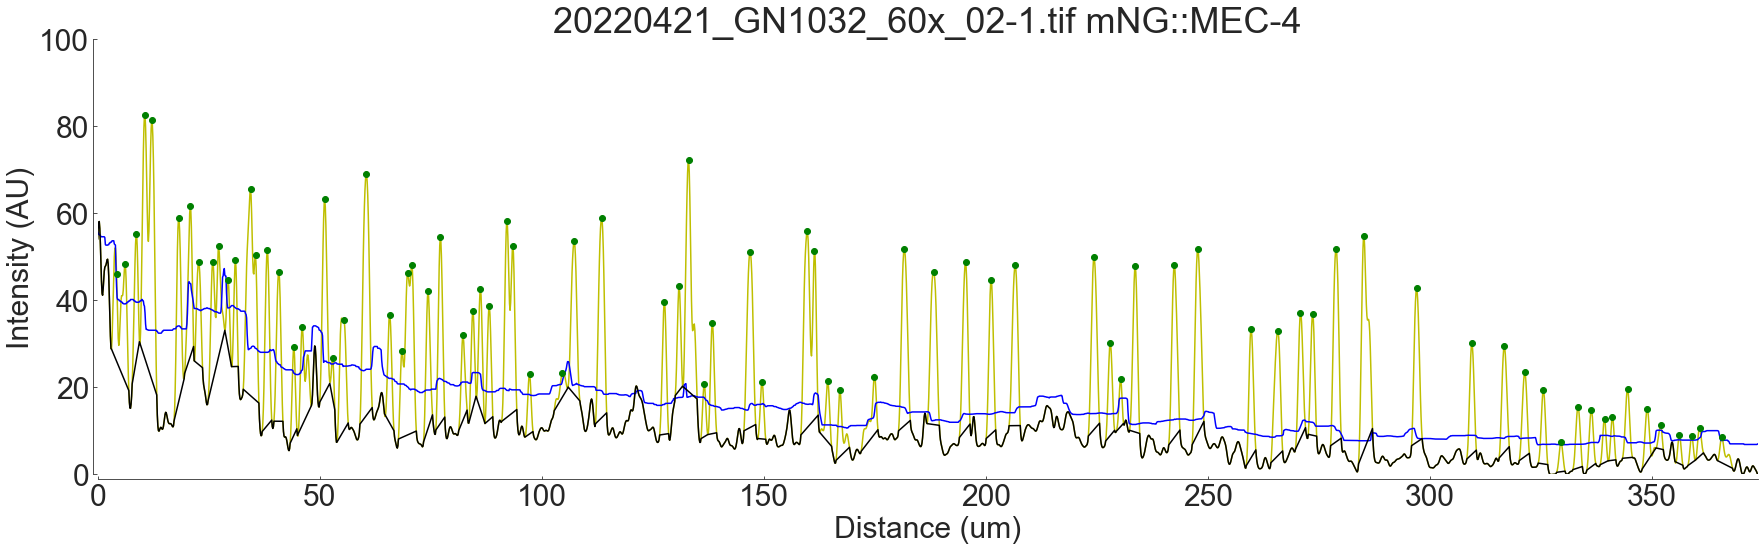

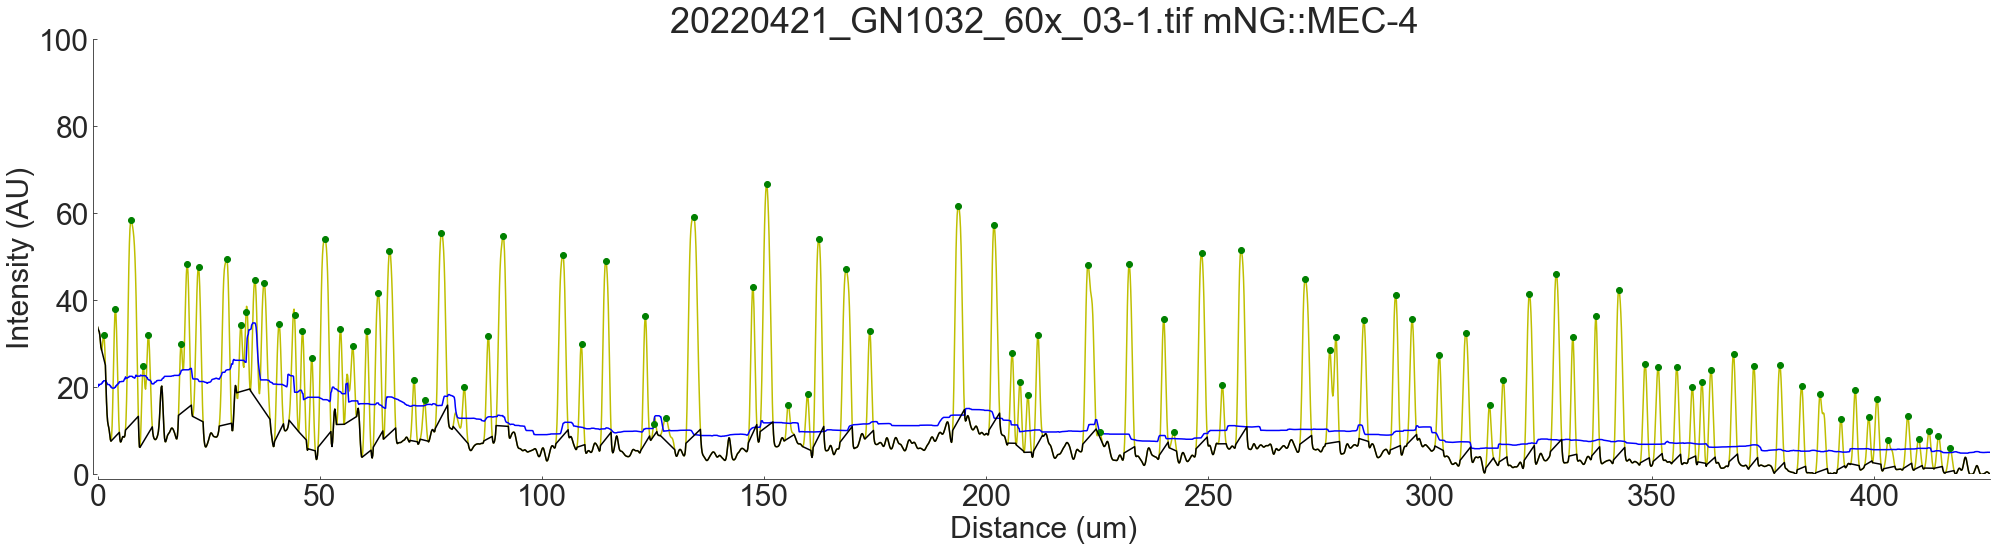

Completed Peak finding in 47.7565 seconds


In [14]:
tic = time.perf_counter()      # optional line to calculate the time taken to run this cell. This is sometimes useful when batch processing many images.

#initialize Pandas DataFrames
df_Data = pandas.DataFrame()
df_Peaks = pandas.DataFrame()
df_IPDs = pandas.DataFrame()
df_Analysis = pandas.DataFrame()
df_Coloc = pandas.DataFrame()
df_fluortypes=pandas.DataFrame()
df_ICQ = pandas.DataFrame()

toa = str(datetime.datetime.today()).split()
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]
os.mkdir(dfpath+timestamp)
os.mkdir(dfpath+timestamp+'/individual_traces')

fpath = askdirectory(title='Select folder where straightened images are stored',parent=window)+'/' # shows dialog box and return the path

cpw=float(input('Camera pixel width (um):'))  # Camera pixel width for Keyence = 7.54
objective=int(input('Objective magnification (_x):').split('x')[0])
age=input('Age of worms:')
neuron=input('Neuron:')

strain_key['n']=0

imgfiles = fnmatch.filter(os.listdir(fpath), '*.tif')

for x in imgfiles:                          #create loop for number of images in folder
    img = imageio.imread(fpath+x)    #import image and store it in a list of lists
    imsize = np.shape(img)[1]                  #calculate image size
    
    #extract info from filename
    date=x.split('_')[0]
    strainID = x.split('_')[1].split('-')[0]
    row_index=strain_key[(strain_key['Strain']==strainID)|(strain_key['Strain_code']==strainID)].index[0]

    strain = strain_key.loc[row_index, 'Strain']
    allele = strain_key.loc[row_index,'Allele']
    channel = strain_key.loc[row_index, 'Channel']
    label =  strain_key.loc[row_index,'Label']

    binning= strain_key.loc[row_index,'Binning']
    mu_per_px = pixel_conversion(binning,objective)

    if label=='mCh::RAB-3;mNG::MEC-4':
        dist_cutoff=int(np.ceil(200/mu_per_px))
        if imsize<dist_cutoff:continue
        else: img=img[:,:dist_cutoff,:]

    count = strain_key.loc[row_index,'n'] + 1
    strain_key.at[row_index,'n']=count

    imsize = np.shape(img)[1]                  #calculate image size
    d=np.arange(imsize)                  #create list of integers from 0 to length of image for x-axis
    dist = d*mu_per_px                      #pixel to microns conversion
    normdist=d/d[-1]

    if channel=='red;green':      
        labelR=label.split(';')[0]
        imgR=img[:,:,0]
        nfR, bsfR, fnfR = neurite_fluorescence(imgR,labelR,binning)
        heightR,prominenceR=height_cutoff(labelR,fnfR)
        dfR, pfR, peaksR, pdR, pndR, pmiR, pmi_nfR, ipdR, ipddR, ipdndR, pwR = peakfinder(fnfR, heightR, prominenceR, nfR, dist)
        
        labelG=label.split(';')[1]
        imgG=img[:,:,1]
        nfG, bsfG, fnfG = neurite_fluorescence(imgG,labelG,binning)
        heightG,prominenceG=height_cutoff(labelG,fnfG)
        dfG, pfG, peaksG, pdG, pndG, pmiG, pmi_nfG, ipdG, ipddG, ipdndG, pwG = peakfinder(fnfG, heightG, prominenceG, nfG, dist)
        
        colocRG, nRG = colocalization(peaksR,peaksG,binning)
        colocGR, nGR = colocalization(peaksG,peaksR,binning)        
        
        apR,df_Data,df_Peaks,df_IPDs,df_Analysis=add_data_to_dataframe(date,strain,allele,labelR,neuron,x,objective,age,imsize,dist,normdist,nfR,dfR,pfR,fnfR,heightR,peaksR,pdR,pndR,pmi_nfR,pwR,colocRG,ipddR,ipdndR,ipdR,df_Data,df_Peaks,df_IPDs,df_Analysis)
        apG,df_Data,df_Peaks,df_IPDs,df_Analysis=add_data_to_dataframe(date,strain,allele,labelG,neuron,x,objective,age,imsize,dist,normdist,nfG,dfG,pfG,fnfG,heightG,peaksG,pdG,pndG,pmi_nfG,pwG,colocGR,ipddG,ipdndG,ipdG,df_Data,df_Peaks,df_IPDs,df_Analysis)           
        
        if len(pdG)==0:frac_GR='N/A'
        else: frac_GR=nGR/len(pdG)
        if len(pdR)==0:frac_RG='N/A'
        else: frac_RG=nRG/len(pdR)

        #compute coloc and non-coloc MEC-4 fluorescence
        ncfG=np.copy(pfG)
        coloc_peaks=apG['Coordinate'][apG['Colocalization']=='yes']
        pw3=peak_widths(fnfG, coloc_peaks, rel_height=0.75)
        for i in np.arange(0, len(coloc_peaks)):
            indices3=np.arange(int(pw3[2][i])-1,int(pw3[3][i])+2)
            ncfG[indices3]=0
        cfG = pfG-ncfG
        
        if label=='mCh::RAB-3;mNG::MEC-4':
            frame1 = pandas.DataFrame({'Date':[date]*imsize, 'Strain':[strain]*imsize, 'Allele':[allele]*imsize, 'Label':[label]*imsize, 'Neuron':[neuron]*imsize, 'ImageID':[x]*imsize, 'Age':[age]*imsize, 'Distance':dist, 'Normalized distance':normdist, 'Neurite intensity':nfG, 'Diffuse fluorescence':dfG, 'Vesicle fluorescence':cfG, 'Non-vesicle puncta fluorescence':ncfG},
                                     columns=cols_fluortypes)
            frame2 = pandas.DataFrame([[date, strain, allele, label, neuron, x, age, len(pdG), len(pdR), nGR, nRG, frac_GR, frac_RG, np.sum(nfG), np.sum(dfG), np.sum(cfG), np.sum(ncfG)]], columns=cols_Coloc)
        else:
            frame1 = pandas.DataFrame({'Date':[date]*imsize, 'Strain':[strain]*imsize, 'Allele':[allele]*imsize, 'Label':[label]*imsize, 'Neuron':[neuron]*imsize, 'ImageID':[x]*imsize, 'Age':[age]*imsize, 'Distance':dist, 'Normalized distance':normdist, 'Neurite intensity':nfG, 'Diffuse fluorescence':dfG, 'Vesicle fluorescence':ncfG, 'Non-vesicle puncta fluorescence':cfG},
                                     columns=cols_fluortypes)
            frame2 = pandas.DataFrame([[date, strain, allele, label, neuron, x, age, len(pdG), len(pdR), nGR, nRG, frac_GR, frac_RG, np.sum(nfG), np.sum(dfG), np.sum(ncfG), np.sum(cfG)]], columns=cols_Coloc)

        df_fluortypes = df_fluortypes.append(frame1)
        df_Coloc = df_Coloc.append(frame2)
        plot_coloc(apG,apR)
        
        #compute ICQ
        icq_full, pearson_full = corr_coeffs(imgG, imgR)
        frame1 = pandas.DataFrame([[strain, label, allele, x, x, imsize, 'full', 'matched', icq_full, pearson_full]], columns=cols_ICQ)
        df_ICQ = df_ICQ.append(frame1)
        continue
    
    else:
        if channel=='red':
            img=img[:,:,0]
        elif channel=='green':
            img=img[:,:,1]
        elif channel=='monochrome':
            img=img
        
        nf, bsf, fnf = neurite_fluorescence(img,label,binning)
        height,prominence=height_cutoff(label,fnf)
        df, pf, peaks, pd, pnd, pmi, pmi_nf, ipd, ipdd, ipdnd, pw = peakfinder(fnf, height, prominence, nf, dist)
        plot_traces_data(x,label,imsize,dist,nf,bsf,df,pd,pmi_nf,height)
        ap, df_Data,df_Peaks,df_IPDs,df_Analysis=add_data_to_dataframe(date,strain,allele,label,neuron,x,objective,age,imsize,dist,normdist,nf,df,pf,fnf,height,peaks,pd,pnd,pmi_nf,pw,'N/A',ipdd,ipdnd,ipd,df_Data,df_Peaks,df_IPDs,df_Analysis)
        continue

if len(df_Coloc)>0:
    df_Coloc['Non-coloc_GR']=df_Coloc['Total green peaks']-df_Coloc['Coloc_GR']
    df_Coloc['Non-coloc_RG']=df_Coloc['Total red peaks']-df_Coloc['Coloc_RG']
    
    df_Coloc['NonFrac_GR']=df_Coloc['Non-coloc_GR']/df_Coloc['Total green peaks']
    df_Coloc['NonFrac_RG']=df_Coloc['Non-coloc_RG']/df_Coloc['Total red peaks']
    
    df_Coloc['Frac_GR'] = pandas.to_numeric(df_Coloc['Frac_GR'], errors='coerce')
    df_Coloc['Frac_RG'] = pandas.to_numeric(df_Coloc['Frac_RG'], errors='coerce')        

#save dataframes as .pkl files. These can be read in a separate python script for plotting and further analysis
df_Data.to_pickle(dfpath+timestamp+'/'+timestamp+'_Data.pkl')
df_Peaks.to_pickle(dfpath+timestamp+'/'+timestamp+'_Peaks.pkl')
df_IPDs.to_pickle(dfpath+timestamp+'/'+timestamp+'_IPDs.pkl')
df_Analysis.to_pickle(dfpath+timestamp+'/'+timestamp+'_Analysis.pkl')
df_fluortypes.to_pickle(dfpath+timestamp+'/'+timestamp+'_Fluortypes.pkl')
df_Coloc.to_pickle(dfpath+timestamp+'/'+timestamp+'_Coloc.pkl')
df_ICQ.to_pickle(dfpath+timestamp+'/'+timestamp+'_ICQ.pkl')
strain_key.to_pickle(dfpath+'strain_key.pkl')    

toc = time.perf_counter()
print(f"Completed Peak finding in {toc-tic:0.4f} seconds")

The cell below saves the dataframes of the _CURRENT_ run only as excel files. If you want to always save dataframes as excel files, this cell can be merged with the above cell. But this process is memory intensive, will slow down the code, and the resulting excel files are often too large to open and process. For these reasons, I put this section in a separate cell. Run it only if you need it.

In [15]:
#save dataframes as excel files 
#Dataframes for summarized strain information
wb = pandas.ExcelWriter(dfpath+timestamp+'/'+timestamp+'_Analysis.xlsx', engine='xlsxwriter')
df_Analysis.to_excel(wb, sheet_name='Analysis')
df_Coloc.to_excel(wb, sheet_name='Coloc')
df_ICQ.to_excel(wb, sheet_name='ICQ')
strain_key.to_excel(wb, sheet_name='Summarized strain info')
wb.save()

#Dataframes storing 1D fluorescence traces of the full neuron
#NOTE: This excel file may be too large depending on the number of images being analysed and may crash excel
wb = pandas.ExcelWriter(dfpath+timestamp+'/'+timestamp+'_1D_neurite_traces_data.xlsx', engine='xlsxwriter')
df_Data.to_excel(wb, sheet_name='Intensity')
df_fluortypes.to_excel(wb, sheet_name='Fractional_intensity')
wb.save()

#Dataframes storing information about the detected peaks
#NOTE: This excel file may be too large depending on the number of images being analysed and may crash excel
wb = pandas.ExcelWriter(dfpath+timestamp+'/'+timestamp+'_Peaks_data.xlsx', engine='xlsxwriter')
df_Peaks.to_excel(wb, sheet_name='Peaks')
df_IPDs.to_excel(wb, sheet_name='IPDs')
wb.save()